In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.datasets import make_classification
sns.set()
%matplotlib inline

from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from sklearn.pipeline import Pipeline
import pickle
import warnings
import scipy
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy import signal

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.simplefilter(action = 'ignore')
plt.style.use('seaborn-white')
sns.set_style('white')

# Problem Statement

Nowadays a huge amount of people are being affected by great variety of stressful factors: we are surrounded by various problems, high load at work or college and many scarefull things. Constant stress can cause chronic fatigue, decrease in activity, weakening of immune system and as the apogee severe mental disorders. As the result people with such disorders are inefficient, morbid and can even harm morally and physically others. Non-indifferent employers, teacher, collegues, friends should pay attention to that problem, that can cause a decrease of employee, student efficiency and a start of one's self-dectructive processes. In addition, prevention and diagnosis are usually cheaper in every sense, rather than the cure. That's why using modern technologies, modern sensors and machine learning algorithms we can save money, time and human resources. For example, an employer concerned about high performance of his employees has to monitor their stress level as it can cause reduced performance and increased probability of making mistakes. Machine learning implementation can increase a quality of that diagnostic sensors, reduce costs of analisys, because cheap and simple sensors with the help of ML can beat up expensive ones. What is more, in case of recent tragic events happening all over the world the task of detecting overstressed ones is extremely relevant.


# CHEST SENSORS 

# FEATURES making


## Temp, EMG, EDA

Due to the fact, that we have a raw data from two sensor devices, feature generation is vital. Using raw data of sensor channels we will go into details of feature creation. From raw data in this part we use several columns: EDA, EMG, TEMP
from either wirst or chest sensor. Let's describe feature generation for every column separately. But for most features generation process has one thing in common: it's done with a sliding window, with a window shift of 0.25 seconds. Raw signals segmented into 1-minute window (Instead of 1-minute window EMG data is processed with 5-seconds window).

Let's start with TEMP data: It's temperature, being mesuared in °C, so for that column we provide some ordinary features. 

This features are:  
* mean value
* standart deviation
* dynamic range
* slope for every window.

Secondly, let's review EMG data feature processing. EMG data represents Electromyography, measured in mV. As mentioned above, this feature process was handled with special 5-seconds window. For this data were generated same features as for Temperature column: mean value, standart deviation, dynamic range for every window.

Thirdly, EDA data is Electrodermal activity, measured in µS. For raw data mean value, standart deviation, dynamic range, slope for every window were processed. After some paper research we discovered the fact, that we can separate EDA into SCL and SCR. The EDA complex includes both background tonic (skin conductance level: SCL) and rapid phasic components (Skin Conductance Responses: SCRs) that result from sympathetic neuronal activity. So after separation, we generated mean and standart deviation features for both parts. This separation is represented on Figure 1. For SCR component we processed interesting feature: number of peaks for every window. Generation of this feature represented in Figure 2.

In [4]:
def MSRS(data,name,f):
    i_025 = int(f*0.25)
    i_60 = int(f*60)
    i = 0
    start = 0
    end = i_60
    
    mean = np.empty(int((len(data) - i_60)/i_025))
    std = np.empty(int((len(data) - i_60)/i_025))
    dynamic_range = np.empty(int((len(data) - i_60)/i_025))
    slope = np.empty(int((len(data) - i_60)/i_025))
    while i*i_025 + i_60 < int(len(data)):
        mean[i] = data[start:end+1].mean()
        std[i] = data[start:end+1].std()
        dynamic_range[i] = 20*np.log10(data[start:end+1].max()/data[start:end+1].min())
        slope[i] = (float(data[end]) - float(data[start]))/i_60
        i += 1
        start = i*i_025
        end = i*i_025 + i_60
    return {'mean_{}'.format(name): mean,'std_{}'.format(name):std,'dynamic_range_{}'.format(name):dynamic_range,'slope_{}'.format(name):slope}

In [5]:
 def decompose_eda(eda):
        scr_list  = []
        b,a = signal.butter(4,0.5/2)
        gsr_filt = signal.filtfilt(b,a,eda,axis=0)
        b,a = signal.butter(4,0.5/2,'highpass')
        scr = signal.filtfilt(b,a,gsr_filt,axis=0)
        scl = [float(x-y) for x,y in zip(gsr_filt,scr)]
        for i in range(len(scr)):
            scr_list.append(scr[i][0])
        return scr_list,scl

In [6]:
def SCRL(scr,scl,f):
    scr = np.array(scr)
    scl = np.array(scl)
    i_025 = int(f*0.25)
    i_60 = int(f*60)
    i = 0
    start = 0
    end = i_60
    mean_l = np.empty(int((len(scr) - i_60)/i_025))
    mean_r = np.empty(int((len(scr) - i_60)/i_025))
    std_l = np.empty(int((len(scr) - i_60)/i_025))
    std_r = np.empty(int((len(scr) - i_60)/i_025))
    peaks = np.empty(int((len(scr) - i_60)/i_025))
    peak = np.empty(int((len(scr) - i_60)/i_025))
    out = {}
    while i*i_025 + i_60 < int(len(scr)):
        mean_r[i] = scr[start:end+1].mean()
        std_r[i] = scr[start:end+1].std()
        mean_l[i] = scl[start:end+1].mean()
        std_l[i] = scl[start:end+1].std()
        peaks[i] = len(signal.find_peaks(scr[start:end+1],height = 0 ,distance=5)[0])
        #if i % 100 ==0: 
        #    print(i)
        i += 1
        start = i*i_025
        end = i*i_025 + i_60
    return {'mean_r': mean_r,'mean_l': mean_l,'std_r':std_r,'std_l':std_l,'peaks':peaks}

In [7]:
def EMG(data,f):
    i_025 = int(f*0.25)
    i_5 = int(f*5)
    i = 0
    start = 0
    end = i_5
    dynamic_range = np.empty(int((len(data) - i_5)/i_025))
    mean = np.empty(int((len(data) - i_5)/i_025))
    std = np.empty(int((len(data) - i_5)/i_025))
    while i*i_025 + i_5 < int(len(data)):
        mean[i] = data[start:end+1].mean()
        std[i] = data[start:end+1].std()
        #print(data[start:end+1].max(), data[start:end+1].min())
        dynamic_range[i] = 20*np.log(abs(data[start:end+1].max())/abs(data[start:end+1].min()))
        #if i % 100 ==0: 
        #    print(i)
        i += 1
        start = i*i_025
        end = i*i_025 + i_5
    return {'mean': mean, 'std':std, 'dynamic_range': dynamic_range}

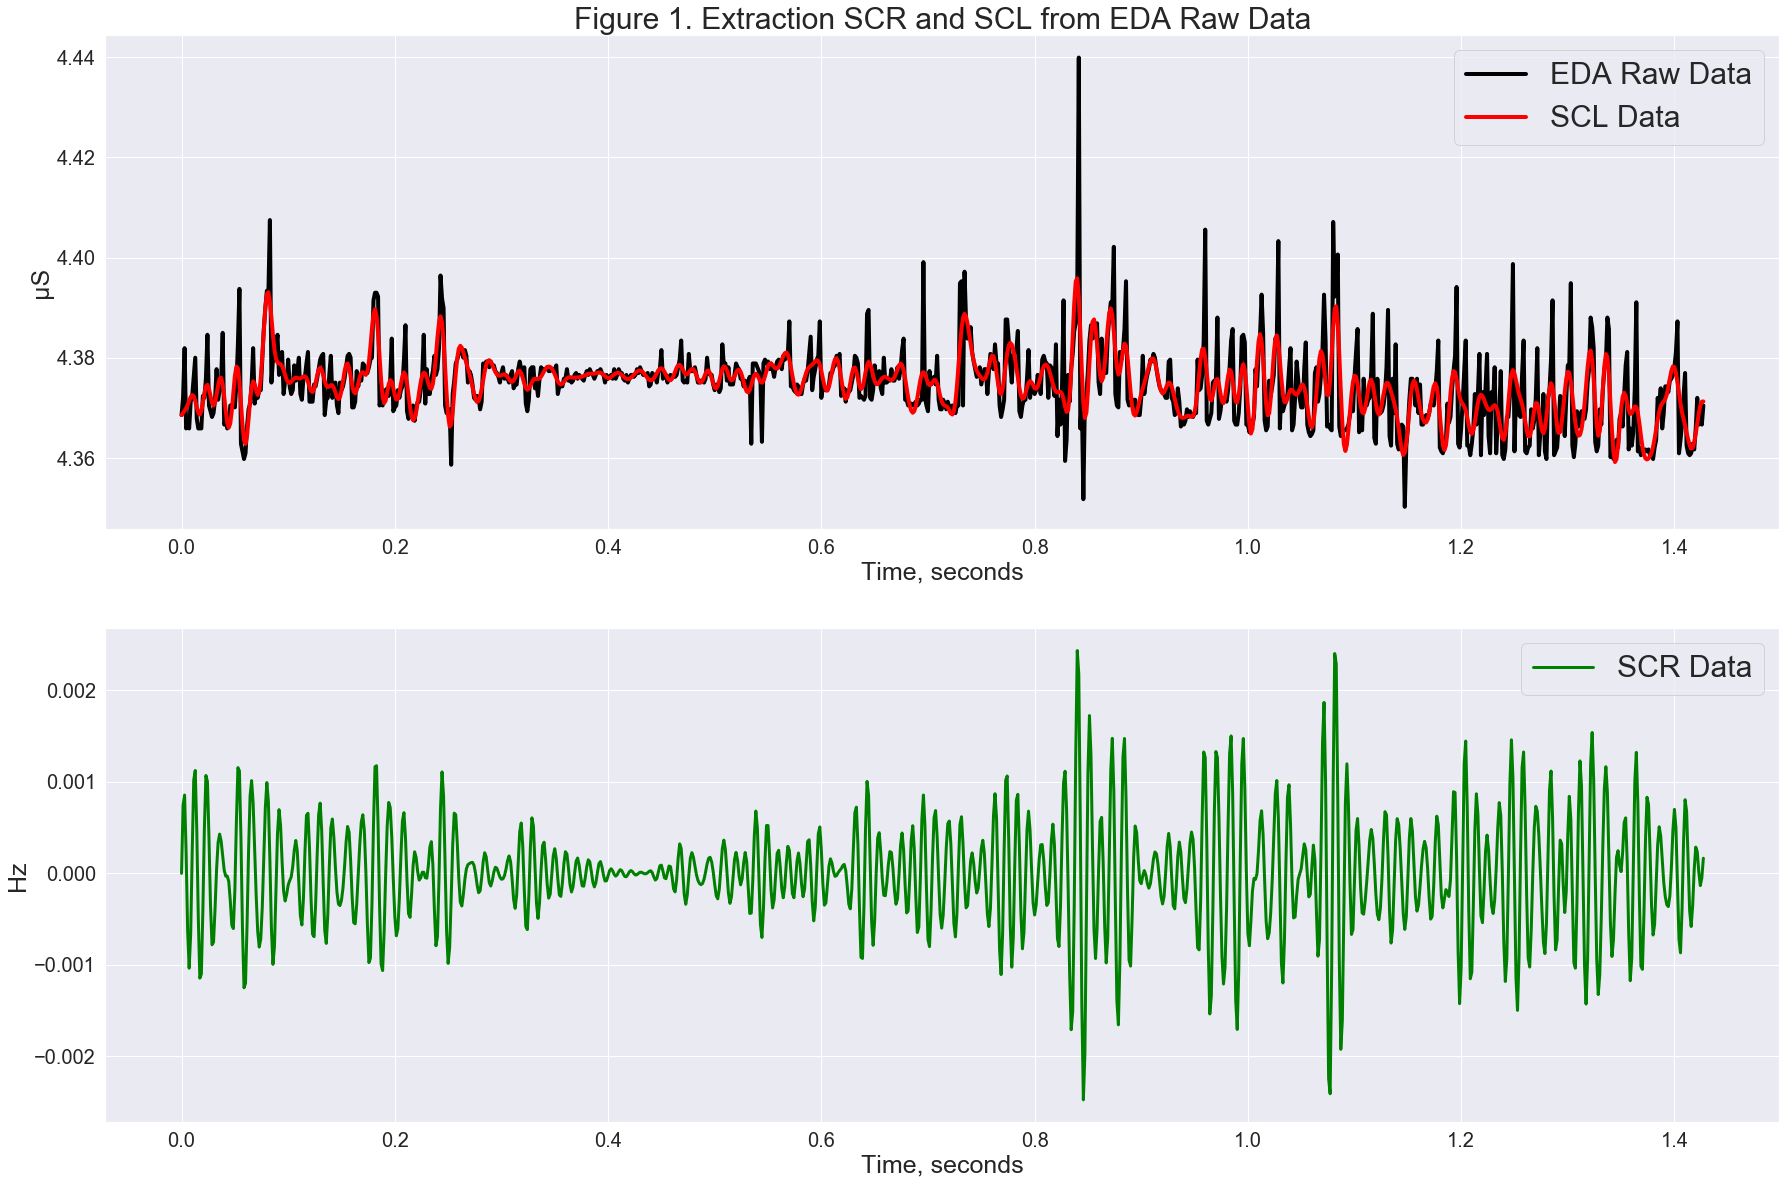

In [14]:
with open('S8.pkl', 'rb') as f:
    data = pickle.load(f,encoding='bytes' )
scr_chest, scl_chest = decompose_eda(data[b'signal'][b'chest'][b'EDA'])

x = np.arange(len(data[b'signal'][b'chest'][b'EDA'][0:1000]))*1/700
plt.figure(figsize=(30,20))
plt.subplot(2, 1, 1)
plt.title('Figure 1. Extraction SCR and SCL from EDA Raw Data', fontsize = 30)
plt.grid(True)
plt.plot(x, data[b'signal'][b'chest'][b'EDA'][0:1000], color = 'black', lw = 4, label = 'EDA Raw Data')
plt.plot(x, scl_chest[0:1000], color = 'red', lw = 4, label = 'SCL Data')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('µS', fontsize = 25)
plt.xlabel('Time, seconds', fontsize = 25)
plt.legend(prop={'size': 30})
plt.subplot(2, 1, 2)
plt.plot(x, scr_chest[0:1000], color = 'green', lw = 3, label = 'SCR Data')
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time, seconds', fontsize = 25)
plt.ylabel('Hz', fontsize = 25)
plt.legend(prop={'size': 30})
plt.show()

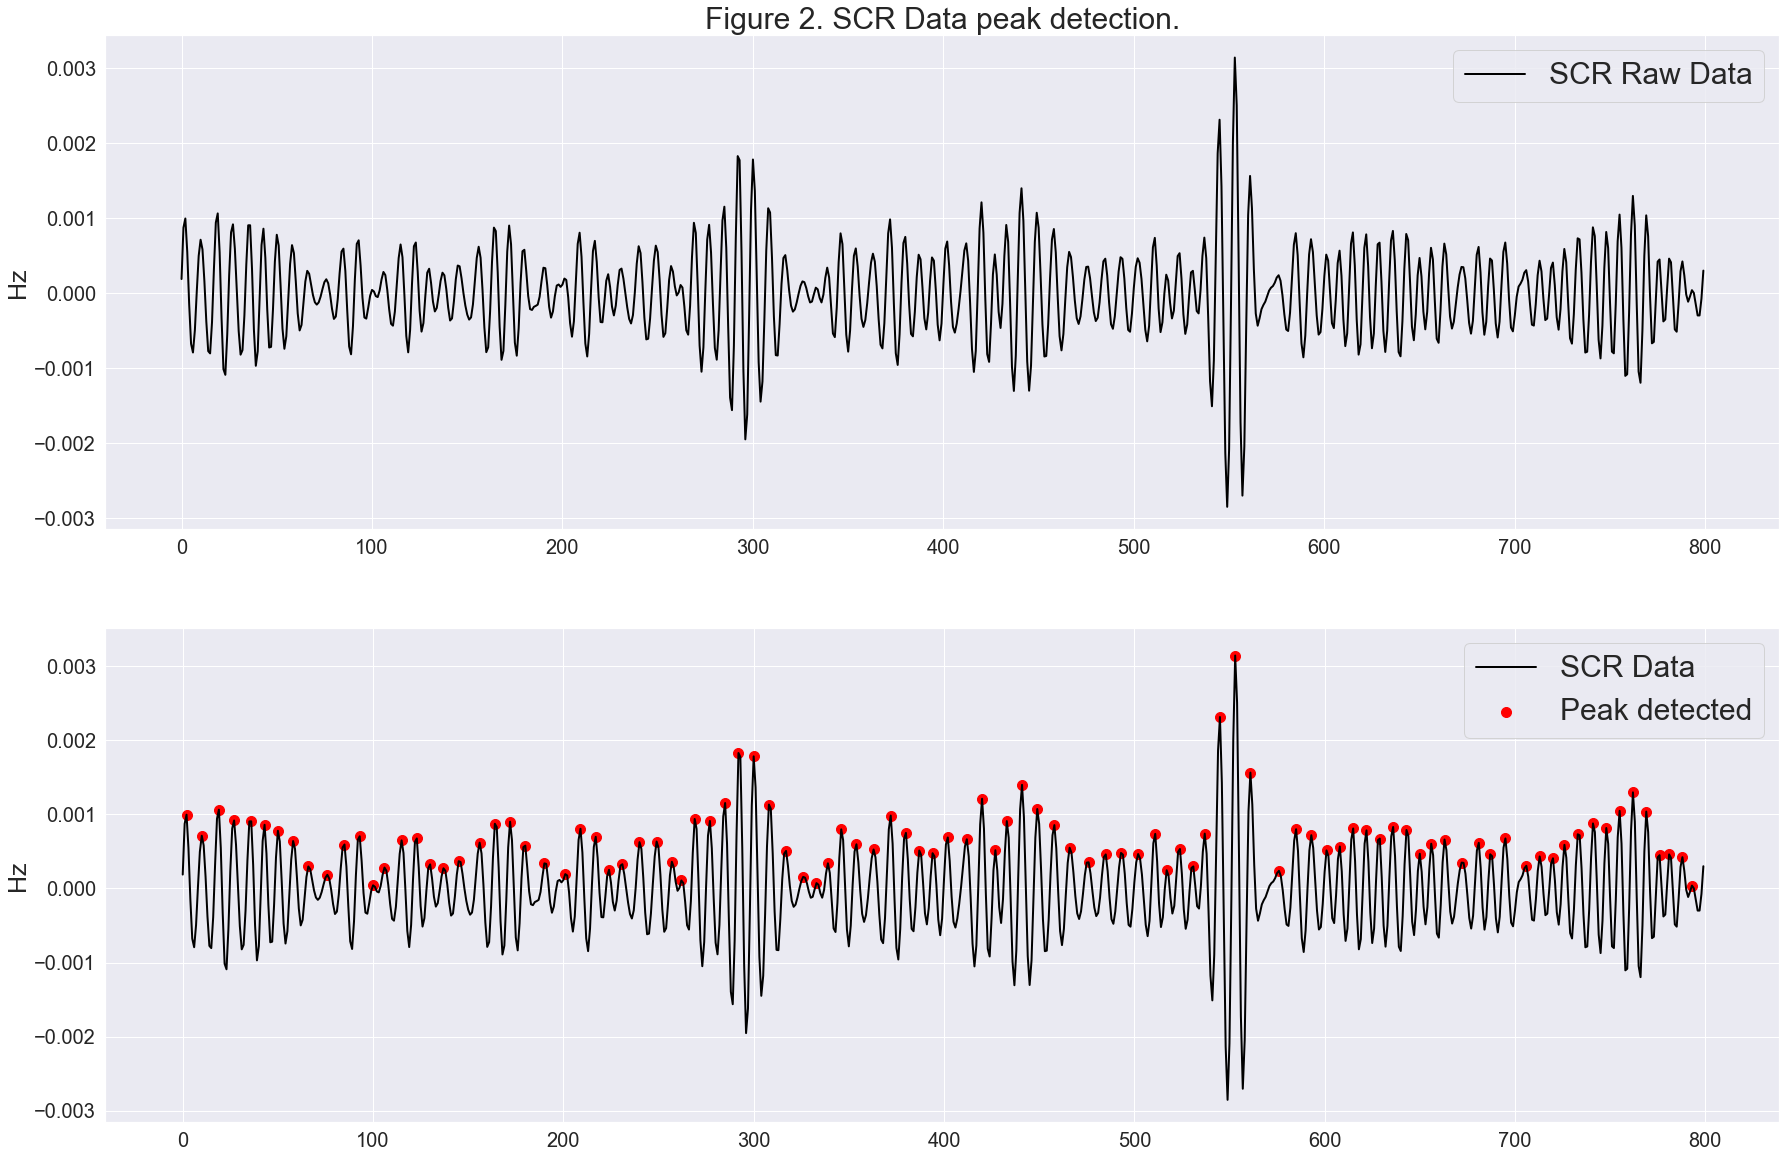

In [15]:
plt.figure(figsize=(30,20))
plt.subplot(2, 1, 1)
plt.title('Figure 2. SCR Data peak detection.', fontsize = 30)
plt.grid(True)
peaks = signal.find_peaks(scr_chest[1600:2400], height = 0 ,distance=5)
plt.plot(scr_chest[1600:2400], color = 'black', lw = 2, label = 'SCR Raw Data')
plt.ylabel('Hz', fontsize = 25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.subplot(2, 1, 2)
peaks = signal.find_peaks(scr_chest[1600:2400], height = 0 ,distance=5)
plt.plot(scr_chest[1600:2400], color = 'black', lw = 2, label = 'SCR Data')
plt.scatter(peaks[0], peaks[1]['peak_heights'], color = 'red', s =100, label = 'Peak detected')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Hz', fontsize = 25)
plt.grid(True)
plt.legend(prop={'size': 30})
plt.show()



# ACC

Another column from raw data is called ACC, which is responsible for accelerometer data, being used describe the nature of the movement. From this data we generated the following features from ACC data: 
* means for all axes and 3D
* standart deviation for all axes and 3D
* max|ACC| for all axes and 3D
* Absolute integral for all axes and 3D, to describe amount of movement
For generating we used a 5-seconds-sized window (same as for EMG). Window shift stays standart, equal to 0.25 seconds. 

Feature generating process represented below.

In [8]:
def intgr(data, timestep):
    return (data[:len(data) - 1].sum() + data[1:].sum())/2*timestep 


def ACC_features(data,window_size,num_0_25_sec,timestep_data, label ):
    ACC_X_mean = []
    ACC_Y_mean = []
    ACC_Z_mean = []
    ACC_X_std = []
    ACC_Y_std = []
    ACC_Z_std = []
    ACC_X_max = []
    ACC_Y_max = []
    ACC_Z_max = []
    ACC_3D_mean =[]
    ACC_3D_std =[]
    ACC_X_iabs = [] 
    ACC_Y_iabs = [] 
    ACC_Z_iabs = [] 
    ACC_3D_iabs =[]
    for i in range(window_size,len(data), num_0_25_sec):
        ACC_X_mean.append( data[:,0][i - window_size:i].mean())
        ACC_X_std.append(data[:,0][i - window_size:i].std())
        ACC_X_max.append(np.fabs(data[:,0][i - window_size:i]).max())
        ACC_X_iabs.append(intgr(np.fabs(data[:,0][i - window_size:i]),timestep_data))
        ACC_Y_mean.append(data[:,1][i - window_size:i].mean())
        ACC_Y_std.append(data[:,1][i - window_size:i].std())
        ACC_Y_max.append(np.fabs(data[:,1][i - window_size:i]).max())
        ACC_Y_iabs.append(intgr(np.fabs(data[:,1][i - window_size:i]),timestep_data))
        ACC_Z_mean.append(data[:,2][i - window_size:i].mean())
        ACC_Z_std.append(data[:,2][i - window_size:i].std())
        ACC_Z_max.append(np.fabs(data[:,2][i - window_size:i]).max())
        ACC_Z_iabs.append(intgr(np.fabs(data[:,2][i - window_size:i]),timestep_data))
        ACC_3D = np.sqrt(data[:,0][i - window_size:i]**2 + data[:,1][i - window_size:i]**2 +data[:,2][i - window_size:i]**2)
        ACC_3D_mean.append(ACC_3D.mean())
        ACC_3D_std.append( ACC_3D.std())
        ACC_3D_iabs.append(intgr(ACC_3D,timestep_data))
    return {'ACC_X_mean' + label :ACC_X_mean,
           'ACC_Y_mean'+ label:ACC_Y_mean,
           'ACC_Z_mean'+ label:ACC_Z_mean,
           'ACC_X_std' + label: ACC_X_std,
           'ACC_Y_std' + label: ACC_Y_std,
           'ACC_Z_std' + label: ACC_Z_std,
            'ACC_X_max'+ label: ACC_X_max,
            'ACC_Y_max'+ label: ACC_Y_max,
            'ACC_Z_max'+ label: ACC_Z_max,
            'ACC_X_iabs'+ label: ACC_X_iabs,
            'ACC_Y_iabs'+ label: ACC_Y_iabs,
            'ACC_Z_iabs'+ label: ACC_Z_iabs,
            'ACC_3D_mean'+ label:ACC_3D_mean,
            'ACC_3D_std'+ label:ACC_3D_std,
            'ACC_3D_iabs'+ label:ACC_3D_iabs  
           }
        
        
    

## ECG

Electrocardiography in dataset represented with ECG column, measured in mV. To add heart behavioral features we generate features:

* Heart Rate mean values , standart deviation, maximum and minimum values for each window. 
* NN50 feature. This features' value is equal to the number of neighboring pairs of peaks in the ECG, for which the distances inside these pairs vary from pair to pair by more than 50 ms 
* pNN50 feature. Percent of NN50
* RMSSD feature. mean value of squared difference between two neighboring pairs peaks distances.
* Average , standart deviation values of distance between peaks
* The energy in different frequency bands: ultra low (ULF: 0.01-0.04 Hz), low (LF: 0.04-0.15 Hz),high (HF: 0.15-0.4 Hz) and ultra high (UHF: 0.4-1.0 Hz) band.
* (LF/HF) Rate feature

From our non-specialist in life sciences point of view, this features describe different biological heart effects, so we accept this data as it is.

Window parameters are standart.

Some words about features:
Here to find distances between peaks, we used find_peaks algorithm to find them. 

To generate feature Energy in different frequency band, we used FFT transform of diff(diff(peaks_places)). We smooth the plot by savgol filter, and used lowpass filter.

In [9]:

def f_fr_n(freq, max_freq, l ):
    if freq < max_freq:
        return int(freq * l/max_freq)
    else:
        return l - 1
    
def Detect_peaks_ECG(data,window_size,num_0_25_sec,timestep_data,distance,label): #150 - respiban
    HR_mean =[]
    HR_std = []
    HR_max = []
    HR_min = []
    N_HRV_50 = []
    P_HRV_50 = []
    rmssd = []
    rr_mean = []
    rr_std = []
    ULF =[]
    HF = []
    LF = []
    UHF = []
    rate_L_H = [] 
    for i in range(window_size,len(data), num_0_25_sec):
        f_p = find_peaks(data[i - window_size:i ], height = 0.4, distance = distance)
        #time features
        f_p_diff = np.diff(f_p[0]) * timestep_data
        
        
        # heart rate mean std min max 

        HR_mean.append((60/f_p_diff).mean())  
        HR_std.append((60/f_p_diff).std()) 
        HR_max.append((60/f_p_diff).max())
        HR_min.append((60/f_p_diff).max())
        #NN50
        #pNN50
        NN50 = sum(np.abs(np.diff(f_p_diff)) > 0.050)
        N_HRV_50.append(NN50)
        P_HRV_50.append(NN50/len(f_p_diff))
        #rr_features
        rmssd.append(np.sqrt(np.mean(np.square(np.diff(f_p_diff)))))
        rr_mean.append(f_p_diff.mean())
        rr_std.append(f_p_diff.std())
        # freq features
        f_p_diff_fft = savgol_filter(np.diff(f_p_diff), 5,2)
        
        T = window_size * timestep_data
        k = np.arange(len(f_p_diff_fft))
        freqs = k/T
        m = freqs.max()/2
        l = int(len(freqs)/2)
        ffts = abs(np.fft.fft(f_p_diff_fft)*np.hamming(len(k)))**2
        ULF.append(sum( ffts[ f_fr_n(0.01,m,l):f_fr_n(0.04,m,l) ] ) )
        HF.append(sum( ffts[ f_fr_n(0.15,m,l):f_fr_n(0.4,m,l) ] ) )
        LF.append(sum( ffts[ f_fr_n(0.04,m,l):f_fr_n(0.15,m,l) ] ) )
        UHF.append(sum( ffts[ f_fr_n(0.4,m,l):f_fr_n(1,m,l) ] ) )
        
        rate_L_H.append(LF[-1]/HF[-1])
        
    return {'HR_mean' + label: np.array(HR_mean),
            'HR_std' + label: np.array(HR_std),
            'HR_max'+ label: np.array(HR_max),
            'HR_min'+ label : np.array(HR_min),
            'NN50' + label: np.array(N_HRV_50),
           'pNN50' + label: np.array(P_HRV_50),
           'rmssd' + label: np.array(rmssd),
           'rr_mean' + label: np.array(rr_mean),
           'rr_std' + label: np.array(rr_std),
           'ULF' + label: np.array(ULF),
           'HF'+ label:np.array(HF),
           'LF'+ label:np.array(LF),
           'UHF'+ label:np.array(UHF),
           'rate_L_H'+ label:np.array(rate_L_H)}
        
        

# RESP features 

Resparation (RESP) features were produced to understand 
stress affect on breathing process of a patient.

Features:
* Inhalation (I) duration mean,std; amplitude max 
* Exhalation (E) duration mean,std; amplitude max
* I/E ratio
* Analog of volume
* Resparation rate , mean, standart deviation values

For generating we used a standart window parameters, described above.

Some words about features:
To find the duration of breathing we used:
1. find_peaks mechanism. It gives very good result, but seldom there were several non-detected peaks. 
2. As the solution of this problem, we proposed algorithm called find_duration, which finds duration only in places where a real rasparation detected without errors.
3. After this algorithm usage, amplitude can be easily determined.
4. As a volume analog we used absolute integral of resp sensor values.

In [10]:

def find_duration(resp_max,resp_min,resp_max_ampl,resp_min_ampl):
    resp_mean_I = []
    resp_mean_E = []
    resp_ampl_I = []
    resp_ampl_E = []
    iterator_I = 0
    iterator_E = 0 
    shift = 0
    for i_max in range(len(resp_max)):
        for i_min in range(shift,len(resp_min)):
            if resp_min[i_min] > resp_max[i_max]:
                shift = i_min 
                if shift > 0:
                    resp_mean_I.append(resp_max[i_max] - resp_min[i_min - 1])
                    resp_ampl_I.append(resp_max_ampl[i_max] - resp_min_ampl[i_min - 1])
                    break;
                if shift == 0:
                    break;
    shift = 0 
    for i_min in range(len(resp_min)):
        for i_max  in range(shift,len(resp_max)):
            if resp_max[i_max] > resp_min[i_min]:
                shift = i_max
                if shift > 0:
                    resp_mean_E.append( resp_min[i_min] - resp_max[i_max - 1]  )
                    resp_ampl_E.append( resp_max_ampl[i_max - 1] - resp_min_ampl[i_min] )
                    break;
                if shift == 0:
                    break;
    return [np.array(resp_mean_I), np.array(resp_mean_E), np.array(resp_ampl_I),np.array(resp_ampl_E)]
                    
    
    
    
def intgr(data, timestep):
    return (data[:len(data) - 1].sum() + data[1:].sum())/2*timestep 
    
    

            
def Resp_features(data,window_size,num_0_25_sec,timestep_data):
    data = savgol_filter(data,15,1)
    resp_I_mean_dr = []
    resp_E_mean_dr = []
    resp_E_std_dr = []
    resp_I_std_dr = [] 
    resp_I_mean = []
    resp_E_mean = []
    resp_E_std = []
    resp_I_std = []
    resp_IE_ratio = [] 
    resp_I_ampl_max = []
    resp_E_ampl_max = []
    volume = []
    resp_rate_mean = []
    resp_rate_std = []
    for i in range(window_size,len(data), num_0_25_sec):
        resp_peak_max = find_peaks(data[i - window_size:i ], height = -1, distance = 200,prominence=True)
        resp_peak_min = find_peaks(- data[i - window_size:i ], height = -1, distance = 200,prominence=True)
        
        #features
        resp_I_E = find_duration(resp_peak_max[0], resp_peak_min[0], 
                                 resp_peak_max[1]['peak_heights'],  - resp_peak_min[1]['peak_heights'])
        resp_I_mean_dr.append(resp_I_E[0].mean() * timestep_data)
        resp_E_mean_dr.append(resp_I_E[1].mean() * timestep_data)      
        resp_I_std_dr.append(resp_I_E[0].std() * timestep_data) 
        resp_E_std_dr.append(resp_I_E[1].std() * timestep_data) 
        resp_IE_ratio.append(resp_I_mean_dr[-1]/resp_E_mean_dr[-1])
        resp_I_ampl_max.append(resp_I_E[2].max())
        resp_E_ampl_max.append(resp_I_E[3].max())
        resp_I_mean.append(resp_I_E[2].mean())
        resp_E_mean.append(resp_I_E[3].mean())
        resp_E_std.append(resp_I_E[2].std())
        resp_I_std.append(resp_I_E[3].std())
        
        
        
        volume.append(intgr(np.fabs(data[i - window_size:i ]),timestep_data))
        resp_rate_mean.append( np.hstack((resp_peak_max[0],resp_peak_min[0])).mean() * timestep_data) 
        resp_rate_std.append( np.hstack((resp_peak_max[0],resp_peak_min[0])).std()* timestep_data) 
        
    return {'resp_I_mean_dur': resp_I_mean_dr,
           'resp_E_mean_dur': resp_E_mean_dr,
           'resp_I_std_dur': resp_I_std_dr,
           'resp_E_std_dur': resp_E_std_dr,
           'resp_IE_ratio' : resp_IE_ratio,
           'resp_I_ampl_max' : resp_I_ampl_max,
           'resp_E_ampl_max' : resp_E_ampl_max,
           'volume':volume,
           'resp_rate_mean':resp_rate_mean,
           'resp_rate_std':resp_rate_std,
           'resp_I_mean': resp_I_mean,
           'resp_E_mean': resp_E_mean,
            'resp_I_std': resp_I_std,
            'resp_E_std': resp_E_std,
           }

# DATA COLLECTION 



Due to the fact, described above, that we have two sensors, placed on chest and wrist, we should pay some attantion to wrist sensor data features. Generally, wrist features use same methods and functions with adaptation, according to raw data parameters, such as frequency, which the raw data was sampled at. 

In [11]:

def make_target(data_new):
    target = []
    for i in range(175, len(data_new[b'label']),175 ):
        target.append(int(data_new[b'label'][i - 175:i].mean()))
    return np.array(target)

def data_collection(data_new):
    numb_of_measures_4_HZ = data_new[b'signal'][b'wrist'][b'EDA'].shape[0]

    experiment_time = numb_of_measures_4_HZ * 0.25

    # ACC_Chest
    ACC = data_new[b'signal'][b'chest'][b'ACC']
    window_size_ts = 5
    number_o_in_0_25_sec = int(data_new[b'signal'][b'chest'][b'ECG'].shape[0]/data_new[b'signal'][b'wrist'][b'EDA'].shape[0])
    window_size_o =  number_o_in_0_25_sec * 4 * window_size_ts 
    timestep_re = numb_of_measures_4_HZ * 0.25/data_new[b'signal'][b'chest'][b'EDA'].shape[0]
    
    ACC_data_chest = pd.DataFrame(ACC_features(ACC, window_size_o,number_o_in_0_25_sec,timestep_re,'_chest'))
    
    
        
    # ECG_chest
    window_size_ts = 60
    number_o_in_0_25_sec = int(data_new[b'signal'][b'chest'][b'ECG'].shape[0]/data_new[b'signal'][b'wrist'][b'EDA'].shape[0])
    window_size_o =  number_o_in_0_25_sec * 4 * window_size_ts 
    timestep_re = numb_of_measures_4_HZ * 0.25/data_new[b'signal'][b'chest'][b'EDA'].shape[0]
    
    ECG = data_new[b'signal'][b'chest'][b'ECG']
    ECG = ECG.reshape((ECG.shape[0],))
    ECG_data_chest = pd.DataFrame(Detect_peaks_ECG(ECG,window_size_o,number_o_in_0_25_sec,timestep_re, distance = 150,label = '_ECG'))
    
    
    
    # Resp_chest
    resp = data_new[b'signal'][b'chest'][b'Resp']
    resp = resp.reshape((resp.shape[0],))
    resp_data = pd.DataFrame(Resp_features(resp,window_size_o,number_o_in_0_25_sec,timestep_re))
    
    
    
    # TEMP_chest
    Temp_chest = pd.DataFrame(MSRS(data_new[b'signal'][b'chest'][b'Temp'],'Temp_chest',700))
    
    #EDA_chest
    EDA_chest = pd.DataFrame(MSRS(data_new[b'signal'][b'chest'][b'EDA'],'EDA_chest',700))
    
    #SRCL_chest
    scr_chest, scl_chest = decompose_eda(data_new[b'signal'][b'chest'][b'EDA'])
    SCRL_chest = pd.DataFrame( SCRL(scr_chest,scl_chest,700))
    
    #EMG_chest
    EMG_chest = pd.DataFrame(EMG(data_new[b'signal'][b'chest'][b'EMG'], 700))
    #all data chest
    data_chest = pd.concat([ACC_data_chest.iloc[:EDA_chest.shape[0]],ECG_data_chest,resp_data,Temp_chest,
                           EDA_chest,SCRL_chest,EMG_chest.iloc[:EDA_chest.shape[0]]] , axis = 1)


    # BVP_wrist 
    
    BVP = data_new[b'signal'][b'wrist'][b'BVP']
    BVP = BVP.reshape((BVP.shape[0],))
    window_size_ts = 60
    number_o_in_0_25_sec_wr = int(data_new[b'signal'][b'wrist'][b'BVP'].shape[0]/data_new[b'signal'][b'wrist'][b'EDA'].shape[0])
    window_size_o_wr = 4 * window_size_ts * number_o_in_0_25_sec_wr
    timestep_wr = numb_of_measures_4_HZ * 0.25/data_new[b'signal'][b'wrist'][b'BVP'].shape[0]
    
    
    BVP_feature = pd.DataFrame(Detect_peaks_ECG(BVP, window_size_o_wr ,number_o_in_0_25_sec_wr,timestep_wr, distance = 25, label = '_BVP'))
    print(BVP_feature.shape)
    
    #ACC_wrist
    ACC = data_new[b'signal'][b'wrist'][b'ACC']
    window_size_ts = 5
    number_o_in_0_25_sec_wr = int(data_new[b'signal'][b'wrist'][b'ACC'].shape[0]/data_new[b'signal'][b'wrist'][b'EDA'].shape[0])
    window_size_o_wr = 4 * window_size_ts * number_o_in_0_25_sec_wr
    timestep_wr = numb_of_measures_4_HZ * 0.25/data_new[b'signal'][b'wrist'][b'ACC'].shape[0]

    ACC_feature = pd.DataFrame(ACC_features(ACC, window_size_o_wr ,number_o_in_0_25_sec_wr,timestep_wr, label = '_wrist'))
    print(ACC_feature.shape)
    #TEMP_WRIST
    Temp_wrist = pd.DataFrame(MSRS(data_new[b'signal'][b'wrist'][b'TEMP'],'Temp_wrist',4))
    #EDA_wrist
    EDA_wrist = pd.DataFrame(MSRS(data_new[b'signal'][b'wrist'][b'EDA'],'EDA_wrist',4))
    #SCRL_wrist
    scr_wrist, scl_wrist = decompose_eda(data_new[b'signal'][b'wrist'][b'EDA'])
    SCRL_wrist = pd.DataFrame(SCRL(scr_wrist,scl_wrist,4))
    data_wrist = pd.concat([ACC_feature[:EDA_wrist.shape[0]],EDA_wrist,Temp_wrist,SCRL_wrist,BVP_feature],axis = 1)


    
    

    return [data_chest , data_wrist]
    

Code for preparing csv files:

In [ ]:
# for text in ['S11.pkl','S17.pkl',
#              'S13.pkl','S14.pkl','S15.pkl','S16.pkl']:
#     with open(text, 'rb') as f:
#         data_new = pickle.load(f,encoding='bytes' )
#     data = data_collection(data_new)
#     data[0]['Target'] = make_target(data_new)[:data[0].shape[0]]
#     data[1]['Target'] = make_target(data_new)[:data[1].shape[0]]
#     data[0].to_csv('features' + '_' + text + 'chest')
#     data[1].to_csv('features' + '_' + text + 'wrist')

We managed to generate 28 dataframes from 14 subjects. For every subject one for chest and one for wrist sensors respectively.

# Feature analisys

make_feature_analisys function:
1. make binary Target value
2. build density distribution functions.

We use it to analize features, to understand which features can be dropped before fitting.

In [3]:
def make_features_analisys(data_1):
    
    data_1['Target'].replace(3,1, inplace = True)
    data_1['Target'].replace(4,1, inplace = True)
    data_1.drop(data_1.loc[data_1['Target'] == 0].index, axis = 0, inplace=True)
    data_1.drop(data_1.loc[data_1['Target'] > 2].index,axis=0,inplace = True)
    data_1['Target'].replace(2,0, inplace = True)
    data_1.index=range(0,data_1.shape[0])
    
    for col in data_1.columns[0:len(data_1.columns)-1]:
        fg = sns.FacetGrid(data_1, hue="Target", aspect=3)
        fg.map(sns.kdeplot, col, shade=True)
        plt.show()
        
    return data_1

Downloading datasets from prepared early files :

In [2]:

datas = []
for i in [2,3,4,5,6,7,9,10,11,13,14,15,16,17]:
    datas.append(pd.read_csv('features_S' + str(i) + '.pklwrist'))
    datas[-1].drop(['Unnamed: 0'],axis = 1, inplace= True)
    datas[-1].dropna(inplace=True)


Making one big dataset and density plots for one subject:

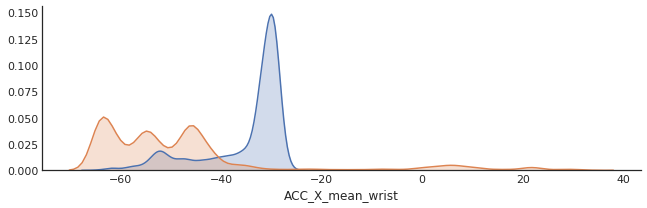

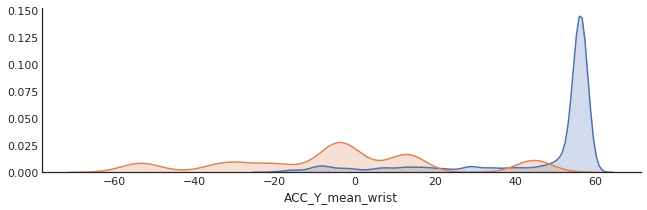

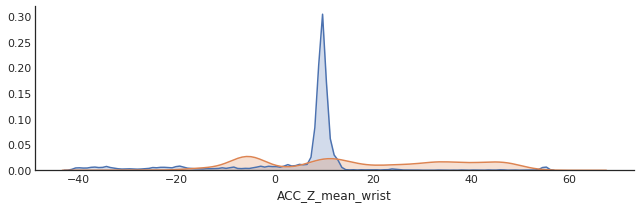

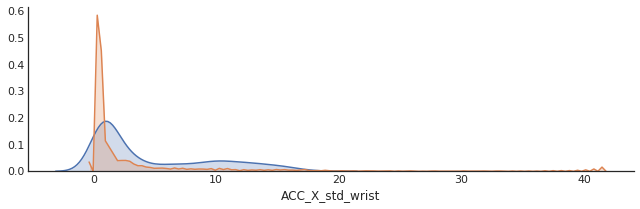

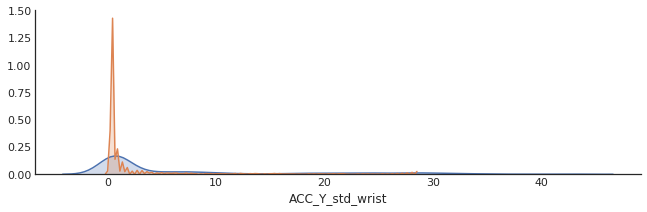

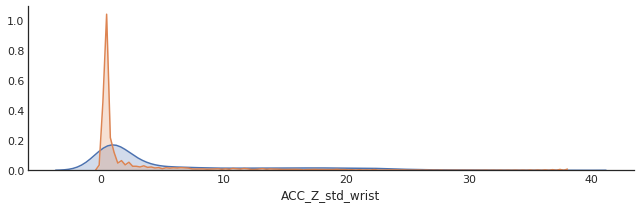

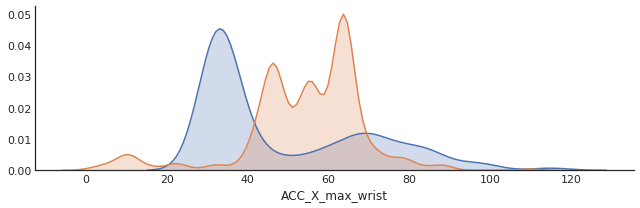

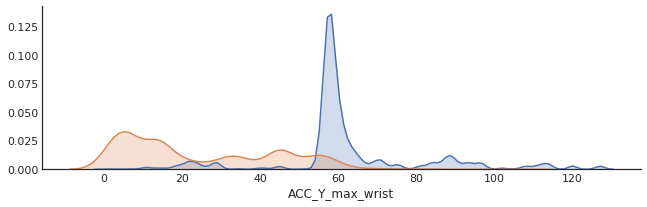

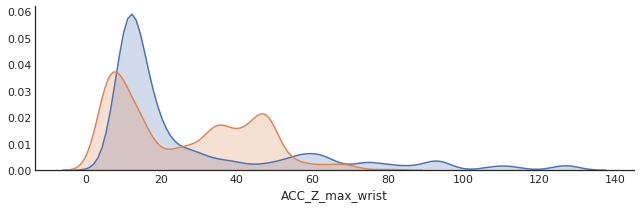

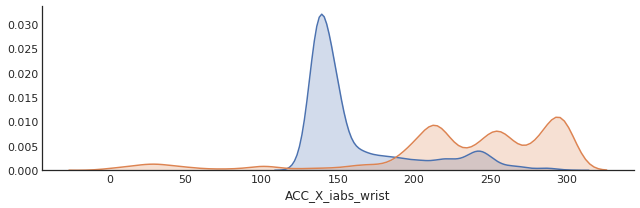

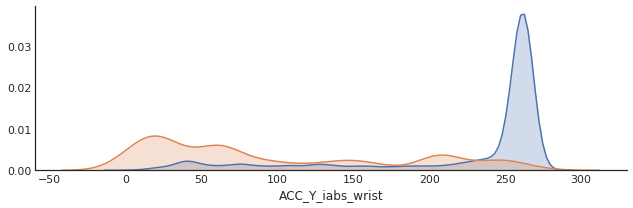

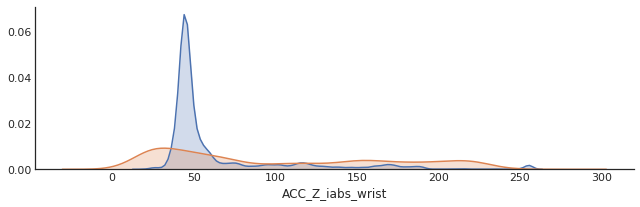

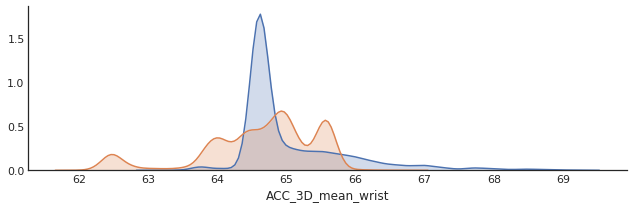

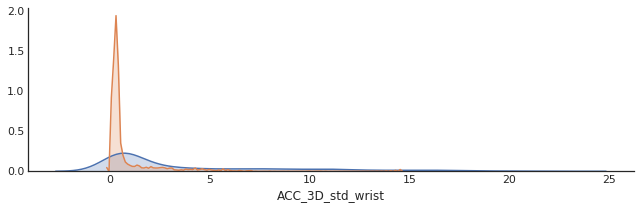

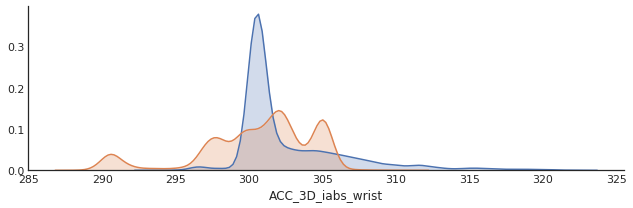

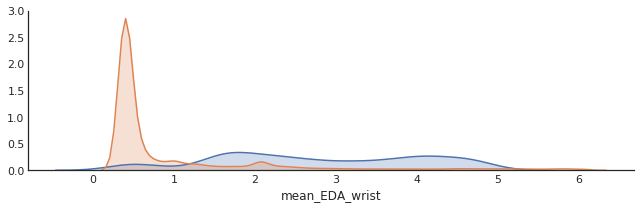

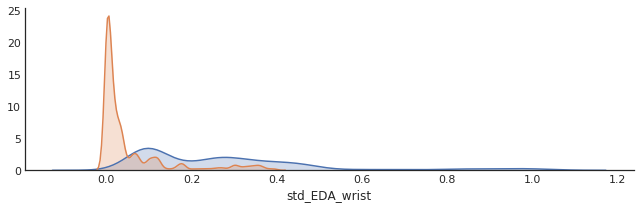

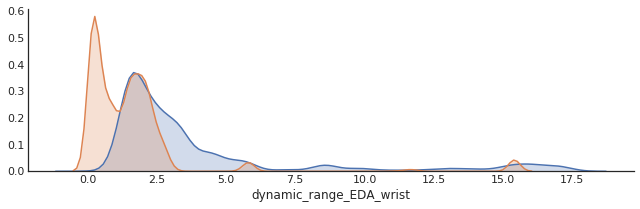

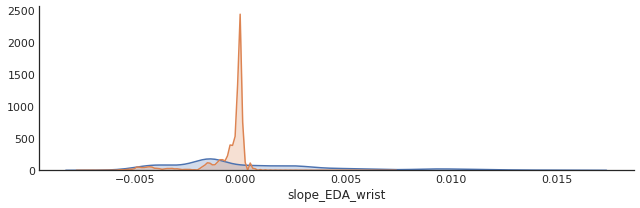

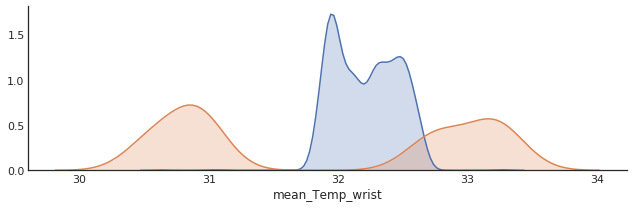

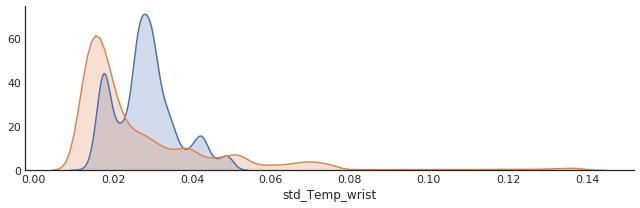

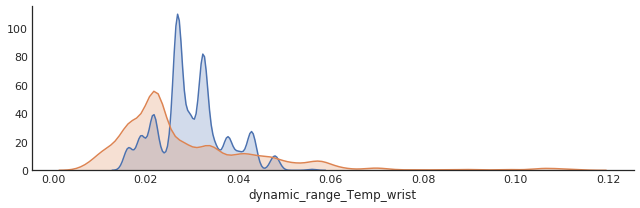

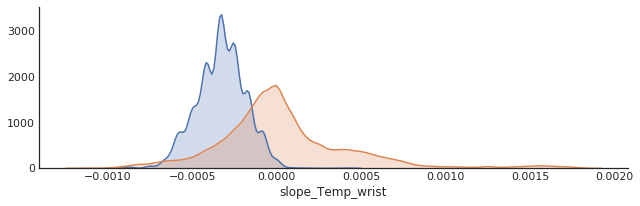

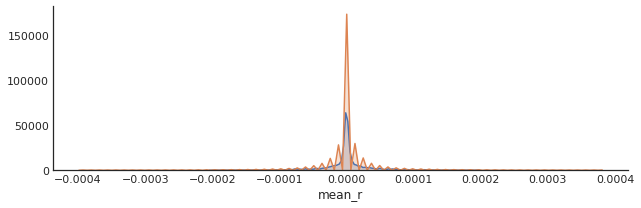

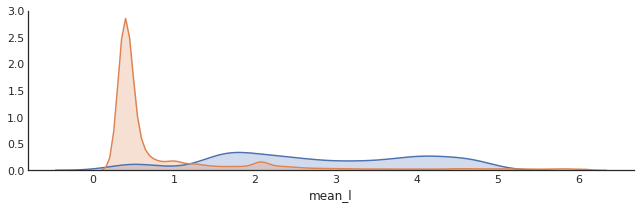

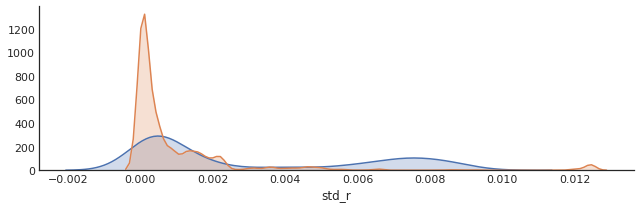

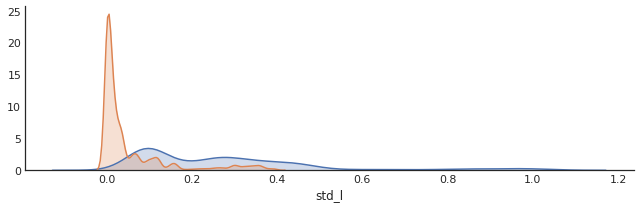

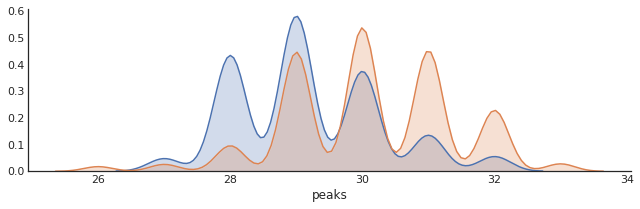

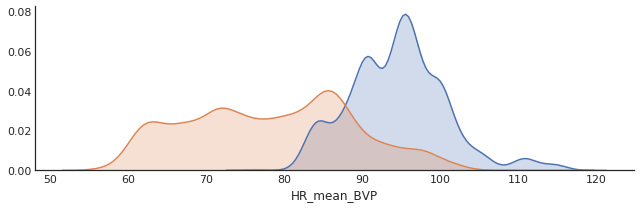

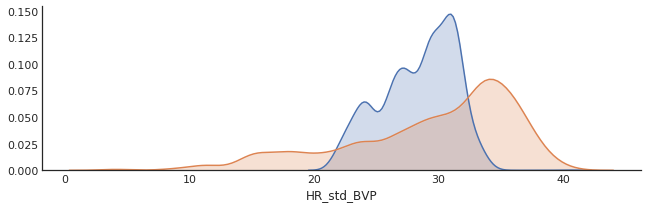

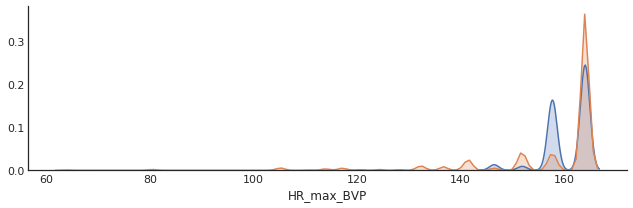

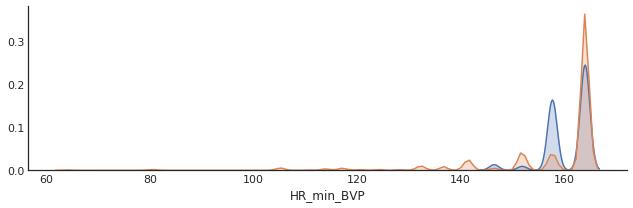

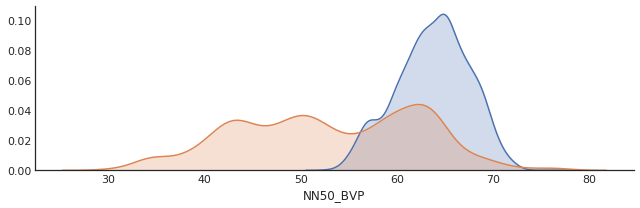

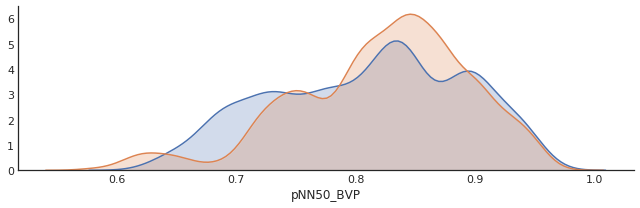

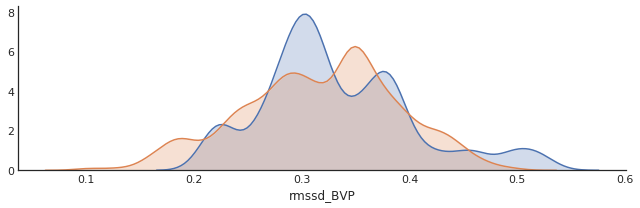

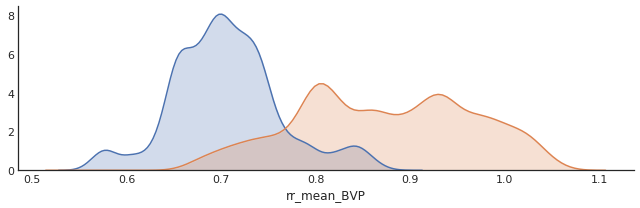

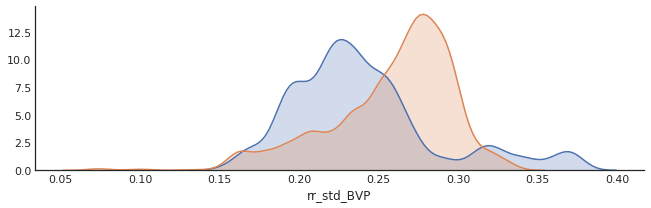

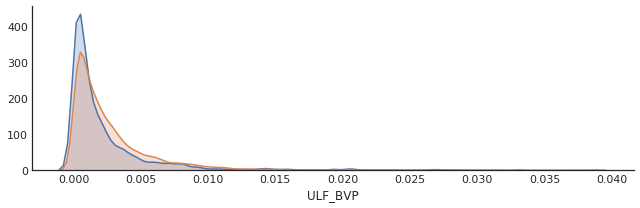

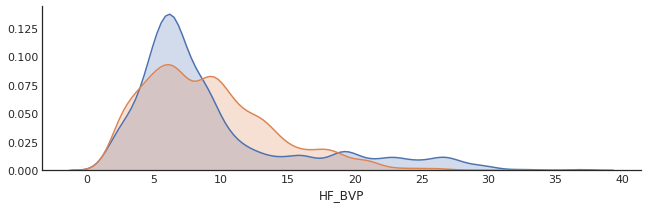

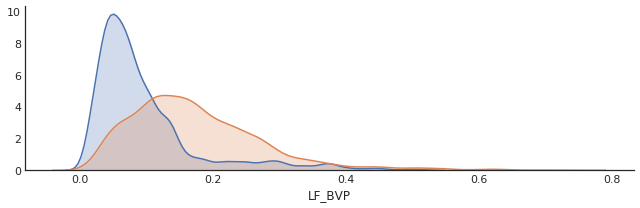

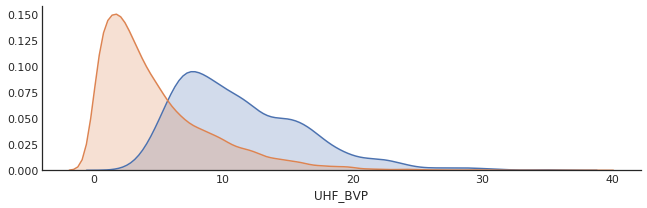

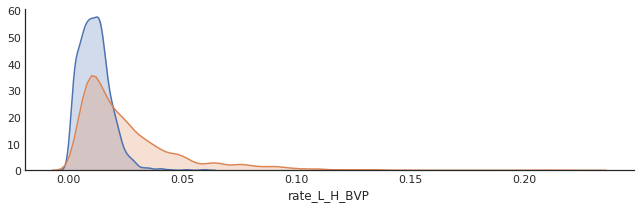

ACC_X_mean_wrist  ACC_Y_mean_wrist  ACC_Z_mean_wrist  ACC_X_std_wrist  \
0             -58.79375         -10.59375           1.68750        12.347620   
1             -58.99375          -9.23750           0.58750        12.396318   
2             -58.74375          -8.33750          -0.12500        12.215895   
3             -59.26875          -7.54375          -0.86875        12.159730   
4             -60.68125          -5.44375          -1.40000        11.182784   
5             -62.04375          -3.00625          -1.36250         9.477174   
6             -63.43750          -1.08125          -2.96250         7.830779   
7             -64.09375           0.13750          -3.62500         6.285695   
8             -62.93125           1.18750          -1.85625         7.261303   
9             -61.90625           2.47500           0.83750         8.375408   
10            -60.58750           4.37500           3.38125         9.889633   
11            -59.78125           5.26875           5.51875        10.027881   
12            -59.31875           6.58125           7.35000        10.368445   
13            -58.37500           7.79375           9.76250        10.246188   
14            -58.08125           8.61875          11.78750        10.155031   
15            -57.53125           8.83750          14.43750        10.277963   
16            -56.87500           9.70000          17.27500        10.367467   
17            -56.06250          10.60000          20.17500        10.745748   
18            -53.78750          11.13125          23.30625        13.345593   
19            -53.26875          10.83750          25.45000        13.191248   
20            -52.75625          10.00625          26.91250        12.848028   
21            -52.51250           8.81875          27.83125        12.680195   
22            -52.43750           7.88750          28.37500        12.611843   
23            -52.35000           7.06875          29.06875        12.485091   
24            -52.16250           6.48125          29.85000        12.284588   
25            -52.01875           5.78125          30.51250        12.149831   
26            -51.71875           5.21875          31.36875        11.656635   
27            -52.05000           4.50000          30.65625        11.728065   
28            -52.91875           3.41250          29.30000        11.720693   
29            -53.80000           1.93125          27.98125        11.618842   
...                 ...               ...               ...              ...   
11718         -45.89375          45.21875           8.26250         0.308157   
11719         -45.92500          45.20625           8.23750         0.263391   
11720         -45.94375          45.20625           8.20000         0.230404   
11721         -45.93750          45.18750           8.18750         0.242061   
11722         -45.93750          45.17500           8.14375         0.242061   
11723         -45.94375          45.19375           8.15000         0.230404   
11724         -45.95625          45.23750           8.16250         0.204538   
11725         -45.91875          45.25625           8.20000         0.273219   
11726         -45.87500          45.28750           8.23750         0.330719   
11727         -45.84375          45.30625           8.28125         0.363092   
11728         -45.80000          45.35000           8.32500         0.400000   
11729         -45.76250          45.39375           8.35625         0.425551   
11730         -45.71250          45.43750           8.37500         0.452597   
11731         -45.66875          45.48125           8.41875         0.470663   
11732         -45.62500          45.52500           8.46250         0.484123   
11733         -45.60000          45.57500           8.50000         0.489898   
11734         -45.55625          45.61250           8.52500         0.496826   
11735         -45.51875          45.65000           8.53750         0.499648   
11736  

In [4]:
data = pd.concat(datas,axis=0,ignore_index=True)
make_features_analisys(datas[1])

Density plots for concatenated subjects:

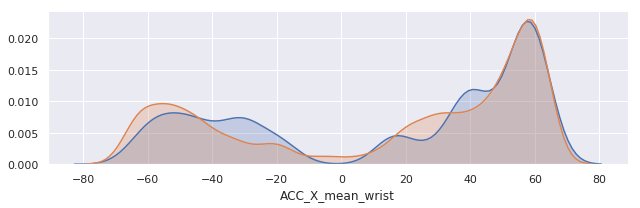

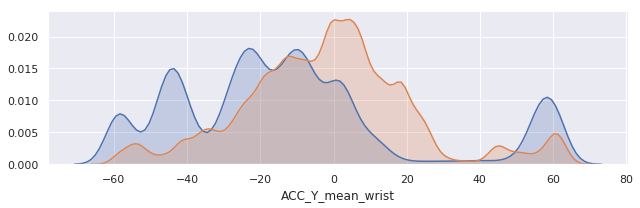

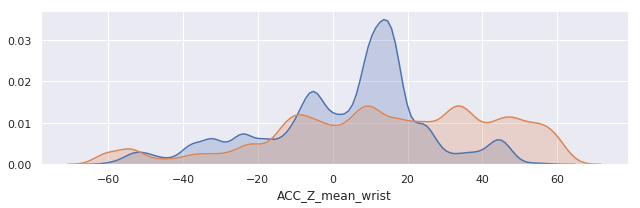

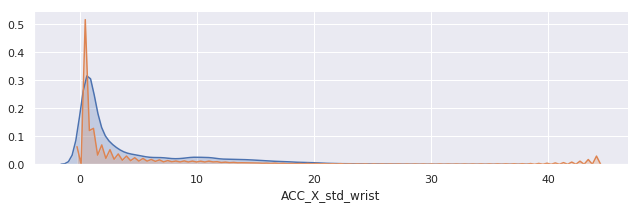

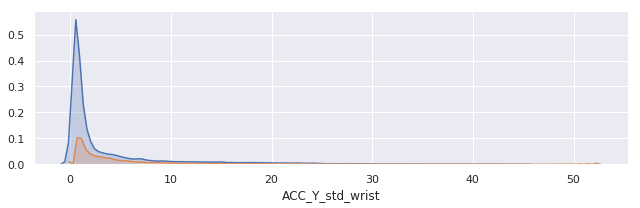

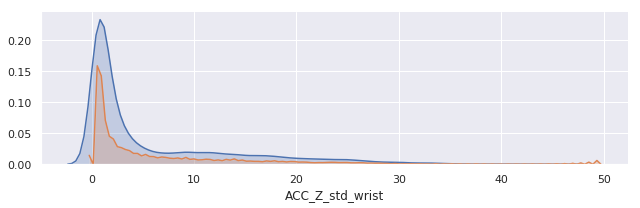

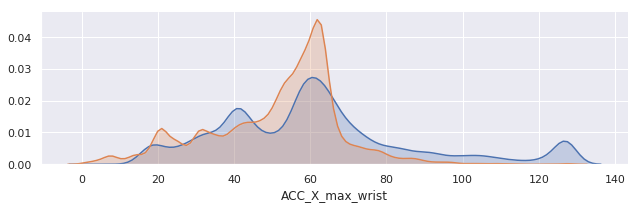

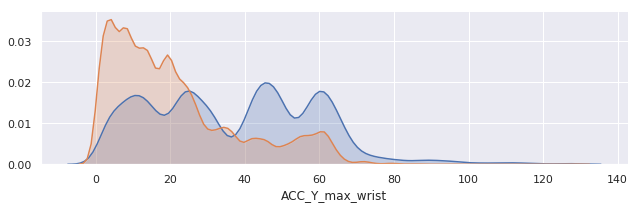

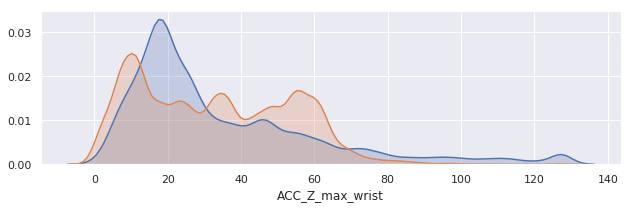

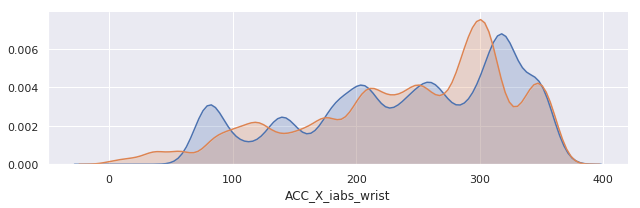

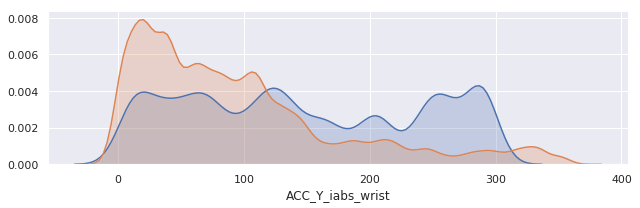

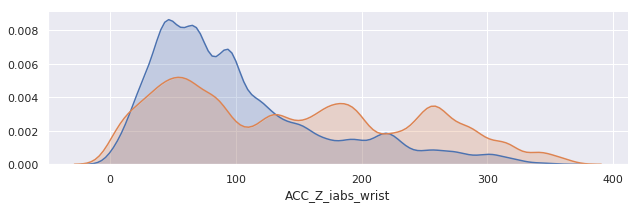

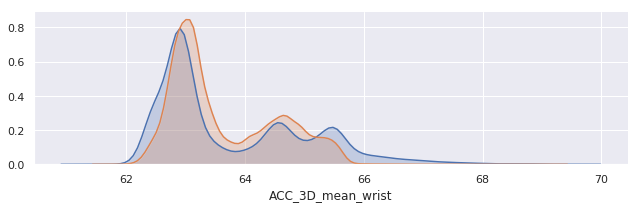

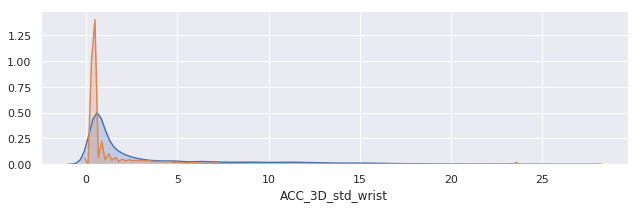

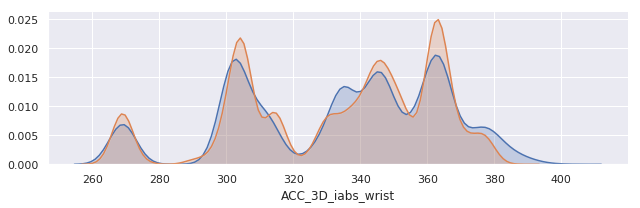

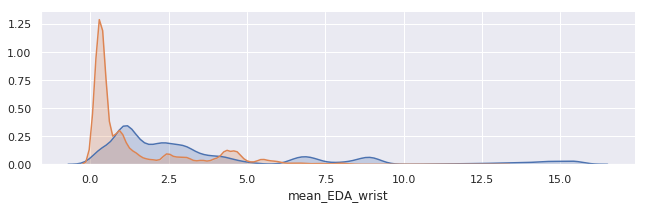

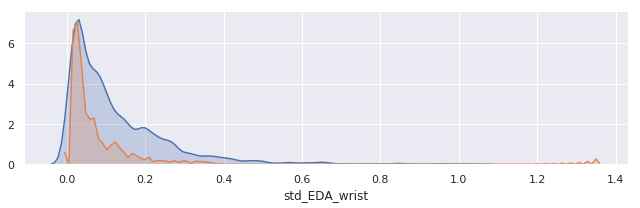

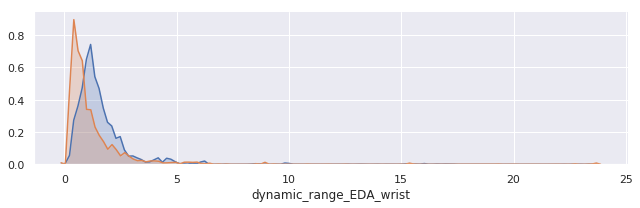

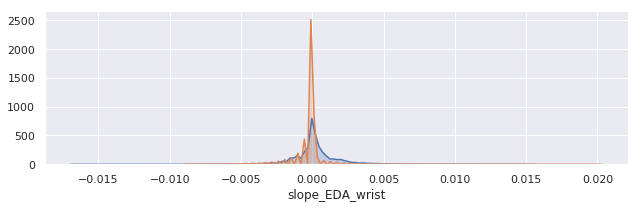

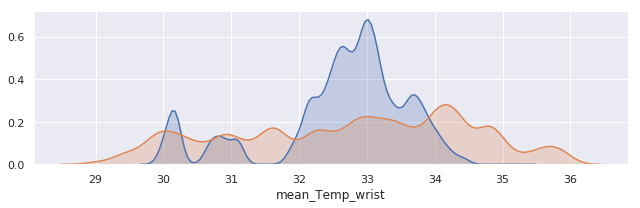

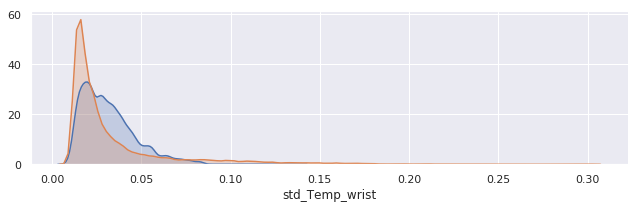

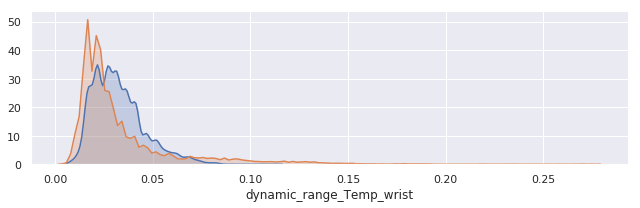

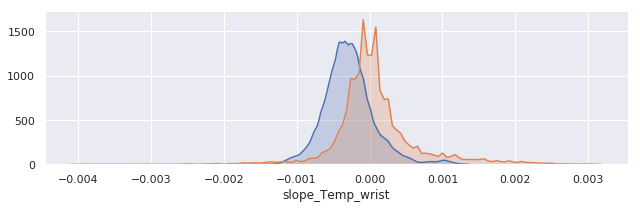

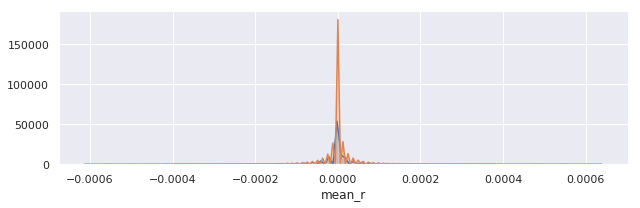

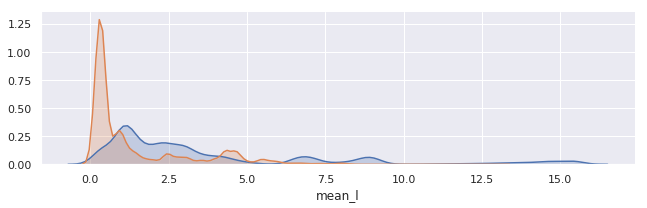

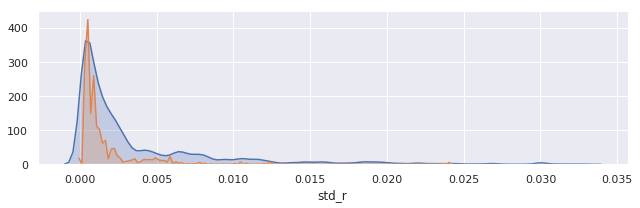

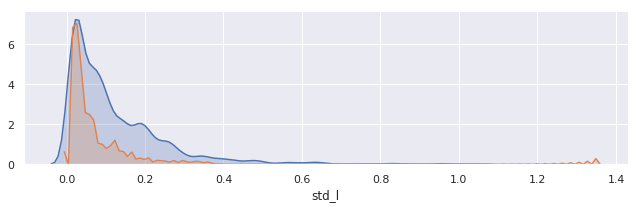

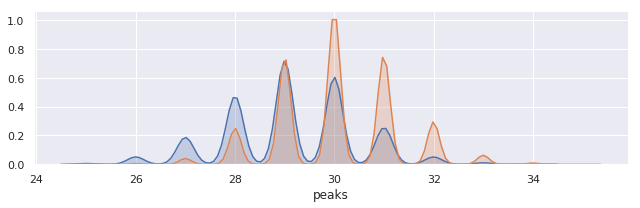

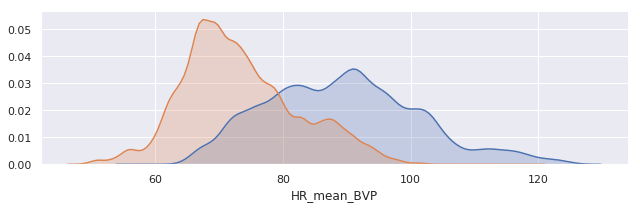

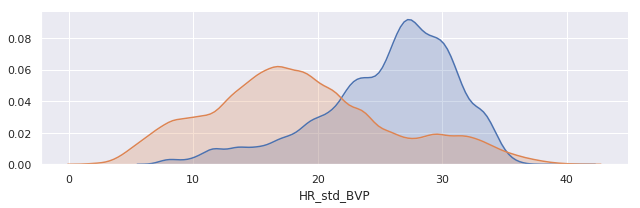

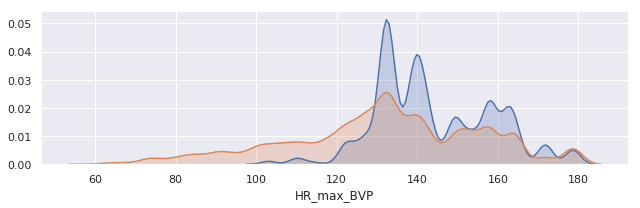

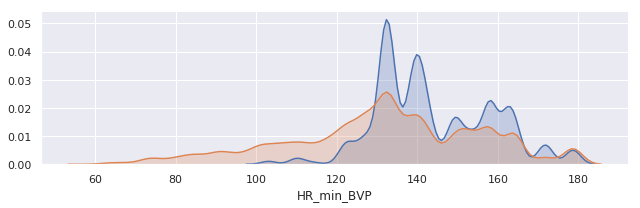

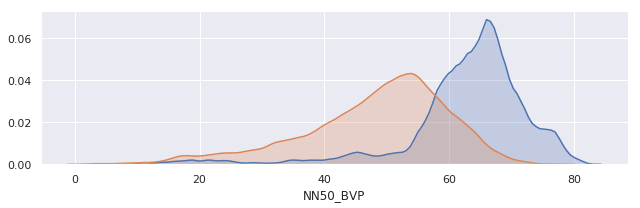

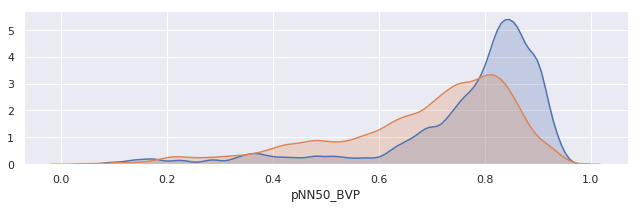

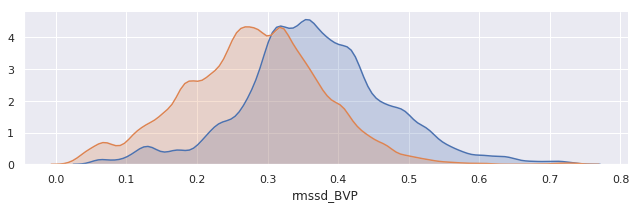

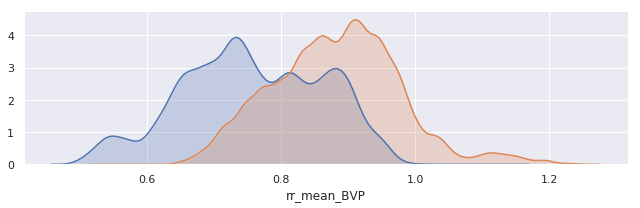

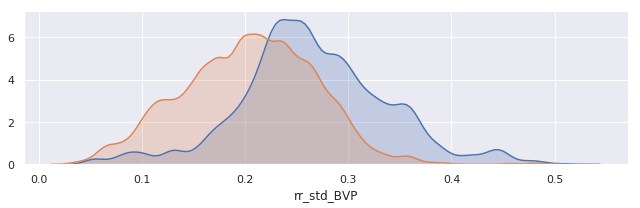

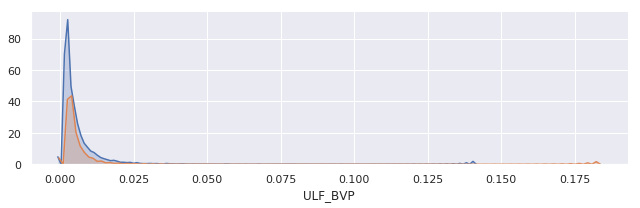

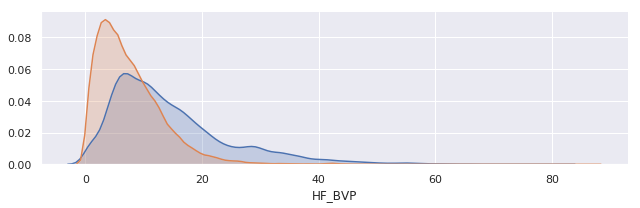

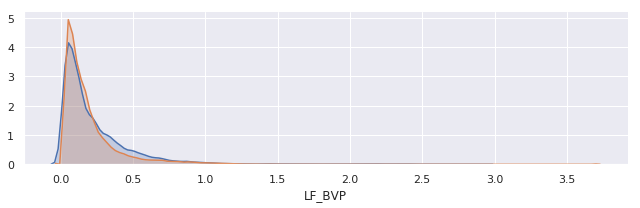

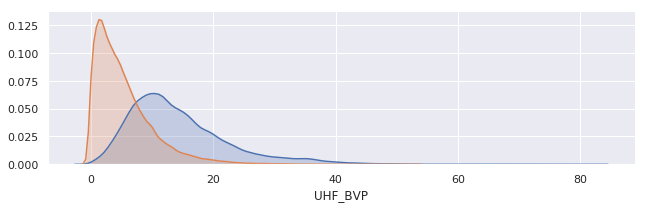

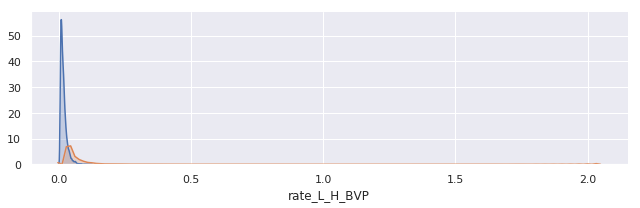

ACC_X_mean_wrist  ACC_Y_mean_wrist  ACC_Z_mean_wrist  ACC_X_std_wrist  \
0               45.06875         -21.01875          38.61250         7.152903   
1               44.50625         -21.56250          38.87500         5.782513   
2               43.58125         -21.36250          39.31875         3.970944   
3               43.08750         -21.43125          39.92500         3.466604   
4               42.52500         -21.57500          40.55000         2.524752   
5               42.03125         -21.66875          41.08750         0.924810   
6               41.93125         -21.79375          41.15625         0.462627   
7               41.93750         -21.82500          41.16875         0.398238   
8               41.95000         -21.88125          41.14375         0.384057   
9               41.95625         -21.91875          41.09375         0.376611   
10              41.99375         -21.93750          41.00625         0.362231   
11              42.06250         -21.95000          40.93125         0.382222   
12              42.08750         -21.98750          40.87500         0.393502   
13              42.09375         -22.02500          40.85625         0.415284   
14              42.10625         -22.06875          40.82500         0.427154   
15              42.13125         -22.06875          40.80625         0.448914   
16              42.15625         -22.05625          40.76250         0.454792   
17              42.21250         -22.05000          40.71875         0.466201   
18              42.25625         -22.05625          40.66875         0.477583   
19              42.28750         -22.07500          40.61875         0.492284   
20              42.31875         -22.09375          40.55625         0.504627   
21              42.35625         -22.10000          40.51250         0.516562   
22              42.37500         -22.13125          40.48125         0.521416   
23              42.37500         -22.14375          40.48125         0.521416   
24              42.36875         -22.16250          40.48125         0.531764   
25              42.35000         -22.20000          40.48750         0.561249   
26              42.33750         -22.23125          40.48750         0.579736   
27              42.33750         -22.26875          40.48125         0.579736   
28              42.34375         -22.29375          40.45625         0.581452   
29              42.38125         -22.35000          40.43750         0.590253   
...                  ...               ...               ...              ...   
167851         -42.71250           5.92500          47.36250         0.466201   
167852         -42.72500           5.92500          47.35625         0.460299   
167853         -42.73750           5.91250          47.35000         0.453975   
167854         -42.75625           5.90000          47.33125         0.443662   
167855         -42.77500           5.89375          47.30625         0.446514   
167856         -42.79375           5.88125          47.28750         0.434409   
167857         -42.81250           5.86250          47.26250         0.421122   
167858         -42.83125           5.86250          47.25000         0.406538   
167859         -42.85625           5.86250          47.23125         0.400732   
167860         -42.86875           5.86250          47.20625         0.389260   
167861         -42.87500           5.86250          47.18125         0.383243   
167862         -42.89375           5.86250          47.15625         0.363952   
167863         -42.90625           5.86875          47.11875         0.331604   
167864         -42.93125           5.88750          47.10000         0.298368   
167865         -42.94375           5.90000          47.08750         0.279439   
167866         -42.95625           5.90625          47.06875         0.258526   
167867         -42.97500           5.90625          47.05000         0.222205   
167868         -42.98750           5.90

In [5]:
make_features_analisys(data)

We analized data from one subject, and have great results. We can separate stress state and calmness with accuracy about 100% for only particular subject. And we can say after analysis(density plots) that below features can't help to separate these classes. So, we decided to drop them .

In [6]:
data.drop(['rate_L_H_BVP' ,'LF_BVP','ULF_BVP', 'pNN50_BVP', 'HR_max_BVP', 'HR_min_BVP', 'mean_r', 'ACC_3D_iabs_wrist', 
 'ACC_3D_mean_wrist', 'ACC_3D_std_wrist', 'ACC_X_std_wrist', 'ACC_Y_std_wrist', 'ACC_Z_std_wrist'], axis=1, inplace=True)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, average_precision_score,
                             precision_recall_curve)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167881 entries, 0 to 167880
Data columns (total 30 columns):
ACC_X_mean_wrist            167881 non-null float64
ACC_Y_mean_wrist            167881 non-null float64
ACC_Z_mean_wrist            167881 non-null float64
ACC_X_max_wrist             167881 non-null float64
ACC_Y_max_wrist             167881 non-null float64
ACC_Z_max_wrist             167881 non-null float64
ACC_X_iabs_wrist            167881 non-null float64
ACC_Y_iabs_wrist            167881 non-null float64
ACC_Z_iabs_wrist            167881 non-null float64
mean_EDA_wrist              167881 non-null float64
std_EDA_wrist               167881 non-null float64
dynamic_range_EDA_wrist     167881 non-null float64
slope_EDA_wrist             167881 non-null float64
mean_Temp_wrist             167881 non-null float64
std_Temp_wrist              167881 non-null float64
dynamic_range_Temp_wrist    167881 non-null float64
slope_Temp_wrist            167881 non-null float64
mean_

In [9]:
data.describe()

ACC_X_mean_wrist  ACC_Y_mean_wrist  ACC_Z_mean_wrist  ACC_X_max_wrist  \
count     167881.000000     167881.000000     167881.000000    167881.000000   
mean          14.309570         -3.688818         11.802324        53.467206   
std           46.017308         25.988195         28.422069        19.855975   
min          -65.381250        -60.562500        -61.887500         1.000000   
25%          -36.262500        -19.675000         -6.400000        41.000000   
50%           34.412500         -4.000000         12.318750        56.000000   
75%           56.143750          9.212500         33.856250        63.000000   
max           63.656250         64.000000         62.768750       128.000000   

       ACC_Y_max_wrist  ACC_Z_max_wrist  ACC_X_iabs_wrist  ACC_Y_iabs_wrist  \
count    167881.000000    167881.000000     167881.000000     167881.000000   
mean         24.520249        33.160822        240.611826        106.398270   
std          19.653755        22.144547         83.083953         88.225790   
min           0.000000         0.000000          0.754099          0.000000   
25%           9.000000        14.000000        185.809958         36.482400   
50%          19.000000        30.000000        255.811227         82.754989   
75%          37.000000        50.000000        305.848800        148.092193   
max         128.000000       128.000000        371.842138        362.533700   

       ACC_Z_iabs_wrist  mean_EDA_wrist      ...                peaks  \
count     167881.000000   167881.000000      ...        167881.000000   
mean         135.621141        1.900671      ...            29.850966   
std           91.327766        2.494453      ...             1.291495   
min            0.000000        0.092475      ...            25.000000   
25%           57.621910        0.325633      ...            29.000000   
50%          116.602260        0.893286      ...            30.000000   
75%          202.213349        2.682586      ...            31.000000   
max          362.276541       15.630504      ...            35.000000   

         HR_mean_BVP     HR_std_BVP       NN50_BVP      rmssd_BVP  \
count  167881.000000  167881.000000  167881.000000  167881.000000   
mean       76.838382      20.150385      51.518081       0.299263   
std        11.783587       7.528195      12.871103       0.105719   
min        48.865213       2.011639       2.000000       0.021893   
25%        68.187013      14.676858      44.000000       0.232356   
50%        74.441424      19.629144      53.000000       0.301390   
75%        84.284544      26.030370      61.000000       0.364545   
max       125.254620      40.641744      82.000000       0.740789   

         rr_mean_BVP     rr_std_BVP         HF_BVP        UHF_BVP  \
count  167881.000000  167881.000000  167881.000000  167881.000000   
mean        0.854614       0.218064       9.096555       7.381660   
std         0.110144       0.070516       7.463200       6.802060   
min         0.496819       0.031407       0.035800       0.000000   
25%         0.779806       0.170706       3.942700       2.465226   
50%         0.862319       0.219748       7.340902       5.499344   
75%         0.928122       0.262949      12.078016      10.187567   
max         1.248259       0.519910      86.830415      81.757231   

              Target  
count  167881.000000  
mean        0.778343  
std         0.415363  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

[8 rows x 30 columns]

We understood that there is too many data for fitting. So we decided to make a big test dataset, to make fitting faster. 

In [17]:
X_tr = data.drop(['Target'], axis=1)    
y_tr = data['Target']
X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, test_size = 0.9, random_state = 42)

#Stratified KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
models = {
    'LR': Pipeline([('scaler', StandardScaler()),  ('log_reg', LogisticRegression())]),
    'RF': Pipeline([('scaler', StandardScaler()),  ('RF', RandomForestClassifier())]),
    'XGB': Pipeline([('scaler', StandardScaler()),  ('XGB', XGBClassifier())]),
    'LDA': Pipeline([('scaler', StandardScaler()),  ('LDA', LinearDiscriminantAnalysis())]),
    'QDA': Pipeline([('scaler', StandardScaler()),  ('QDA', QuadraticDiscriminantAnalysis())])
}

parameters = {
    'LR': {
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__C': [10, 5, 3, 1],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'RF': {
        'RF__max_depth': [2, 5, 8], 
        'RF__n_estimators': [100, 500, 800],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'XGB': {
        'XGB__max_depth': [2, 5, 8],
        'XGB__n_estimators': [100, 500, 800],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'LDA': {
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
        
    },
    'QDA': {
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
        
    }
}

durations = {
    'LR': 0,
    'RF': 0,
    'XGB': 0,
    'LDA': 0,
    'QDA': 0
}
labels_proba = {
    'LR_tr': 0,
    'LR_te': 0,
    'RF_tr': 0,
    'RF_te': 0,
    'XGB_tr': 0,
    'XGB_te': 0,
    'LDA_tr': 0,
    'LDA_te': 0,
    'QDA_tr': 0,
    'QDA_te': 0
}
labels_predict = {
    'LR_tr': 0,
    'LR_te': 0,
    'RF_tr': 0,
    'RF_te': 0,
    'XGB_tr': 0,
    'XGB_te': 0,
    'LDA_tr': 0,
    'LDA_te': 0,
    'QDA_tr': 0,
    'QDA_te': 0
}

In [ ]:
def print_results(name, y_te, prob_te, pred_te, params, time):
    roc_te = roc_auc_score(y_te, prob_te)
    ac_te = accuracy_score(y_te, pred_te)
    f1_te = f1_score(y_te, pred_te)
    print('{} with best params: {}'.format(name, params[name]))
    print('\t                 Value')
    print('\tAccuracy:        {:.3f}'.format(ac_te))
    print('\tF1 score:        {:.3f}'.format(f1_te))
    print('\tROC_AUC:         {:.3f}'.format(roc_te))
    print('\tFit duration:    {:.3f}'.format(time))

In [19]:
def draw_pr_curve(recall, precision, average_precision):
    
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()
    
def print_stats(y_te, y_pred, y_prob):
    
    print(classification_report(y_te, y_pred))
    print('roc_auc \t {0:0.3f}'.format(roc_auc_score(y_te, y_prob)))
    
    # Draw precision-recall curve
    precision, recall, _ = precision_recall_curve(y_te, y_prob)
    draw_pr_curve(recall, precision, average_precision_score(y_te, y_pred))
    
    # Draw confusion matrix
    sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt="d")
    plt.show()
    
def print_stats_threshold(y_te, y_prob, thr):
    y_res = y_prob > thr
    
    print(classification_report(y_te, y_res))
    print('roc_auc \t {0:0.3f}'.format(roc_auc_score(y_te, y_prob)))
    
    # Draw precision-recall curve
    precision, recall, _ = precision_recall_curve(y_te, y_prob)
    draw_pr_curve(recall, precision, average_precision_score(y_te, y_res))
    
    # Draw confusion matrix
    sns.heatmap(confusion_matrix(y_te, y_res), annot=True, fmt="d")
    plt.show()

Fit LR
For LR best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('log_reg', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]) 
best params = {'log_reg__C': 10, 'log_reg__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.90      0.87      0.88     33520
           1       0.96      0.97      0.97    117573

   micro avg       0.95      0.95      0.95    151093
   macro avg       0.93      0.92      0.93    151093
weighted avg       0.95      0.95      0.95    151093

roc_auc 	 0.985


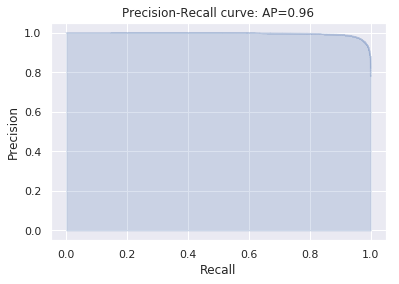

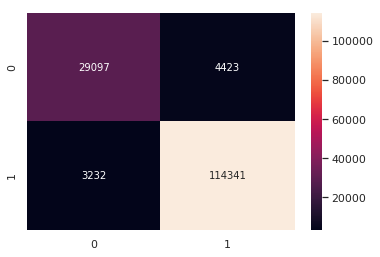

Fit RF
For RF best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]) 
best params = {'RF__max_depth': 8, 'RF__n_estimators': 800}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33520
           1       1.00      1.00      1.00    117573

   micro avg       0.99      0.99      0.99    151093
   macro avg       0.99      0.99      0.99    151093
weighted avg       0.99      0.99      0.99    151093

roc_auc 	 1.000


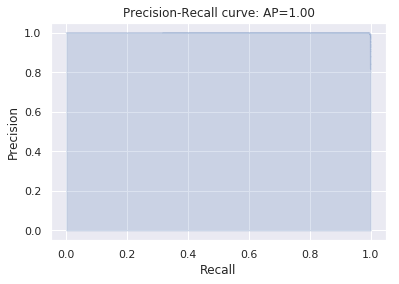

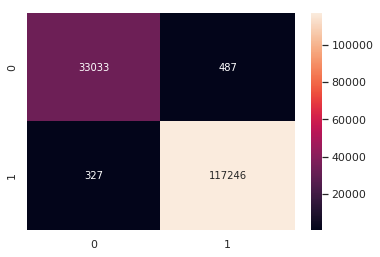

Fit XGB
For XGB best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]) 
best params = {'XGB__max_depth': 5, 'XGB__n_estimators': 800}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33520
           1       1.00      1.00      1.00    117573

   micro avg       1.00      1.00      1.00    151093
   macro avg       1.00      1.00      1.00    151093
weighted avg       1.00      1.00      1.00    151093

roc_auc 	 1.000


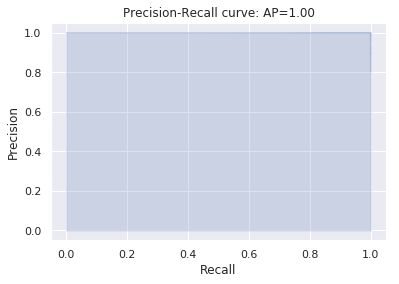

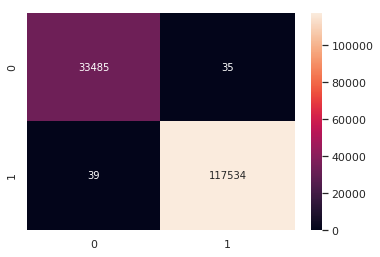

Fit LDA
For LDA best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]) 
best params = {}
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     33520
           1       0.94      0.98      0.96    117573

   micro avg       0.94      0.94      0.94    151093
   macro avg       0.94      0.89      0.91    151093
weighted avg       0.94      0.94      0.94    151093

roc_auc 	 0.974


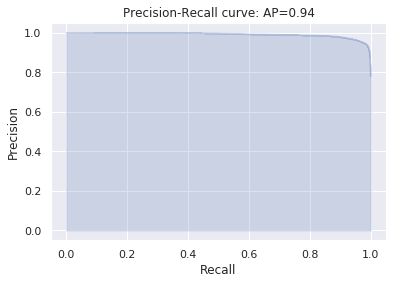

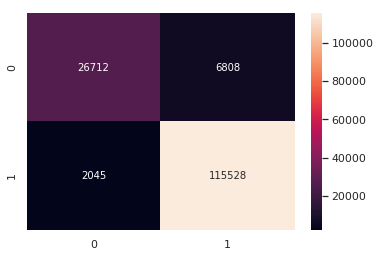

Fit QDA
For QDA best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('QDA', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001))]) 
best params = {}
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     33520
           1       0.96      0.97      0.96    117573

   micro avg       0.94      0.94      0.94    151093
   macro avg       0.92      0.91      0.91    151093
weighted avg       0.94      0.94      0.94    151093

roc_auc 	 0.978


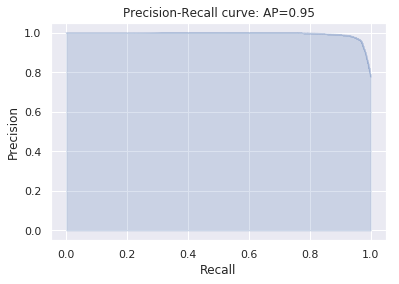

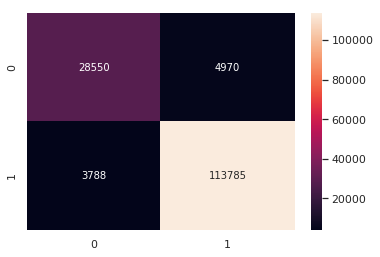

In [20]:
for model_name in models.keys():
    print('Fit ' + model_name)
    warnings.simplefilter(action='ignore')
    clf = GridSearchCV(models[model_name], parameters[model_name],
                       cv=cv, n_jobs=-1,scoring = 'f1')
    clf.fit(X_tr, y_tr)
    print ('For {} best estimator = {} \nbest params = {}'.format(model_name, clf.best_estimator_, clf.best_params_))
    # Predition part
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:,1]
    labels_proba[model_name + '_te'] = y_prob
    labels_predict[model_name + '_te'] = clf.predict(X_te)
    
    print_stats(y_te, y_pred, y_prob)

doing the same with chest sensor data:

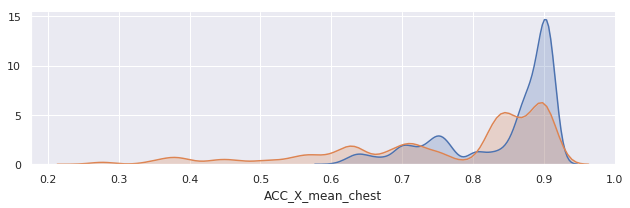

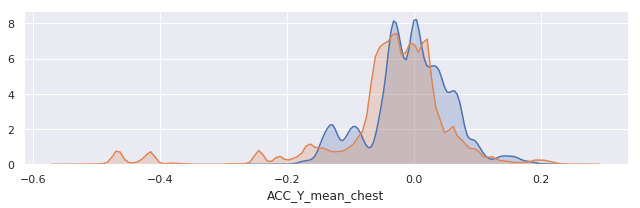

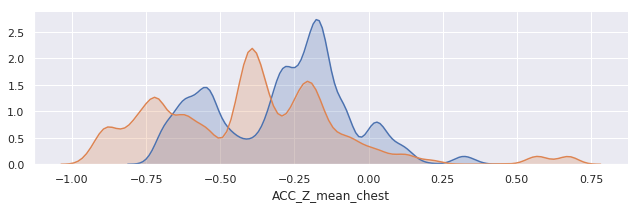

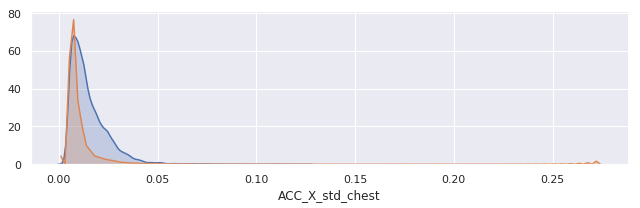

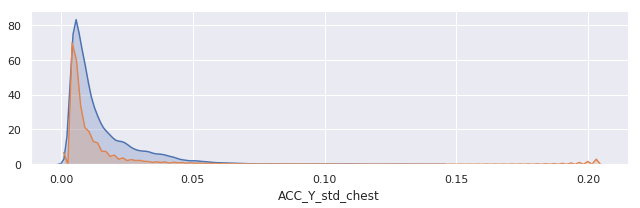

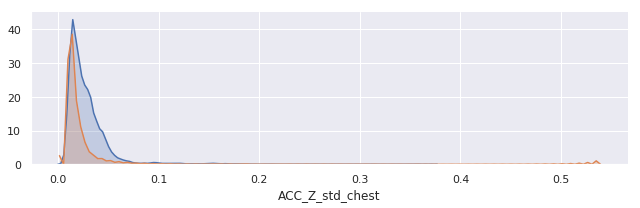

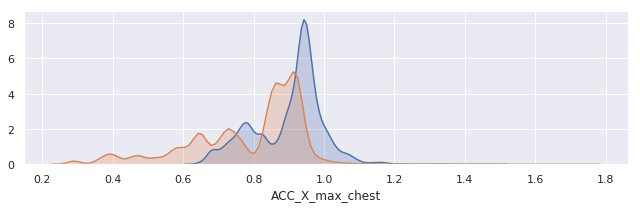

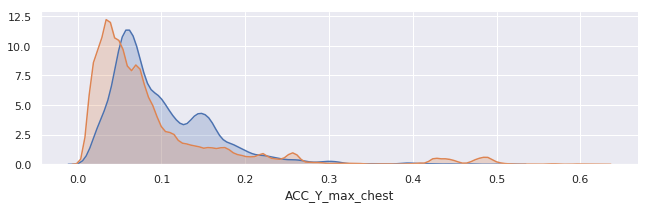

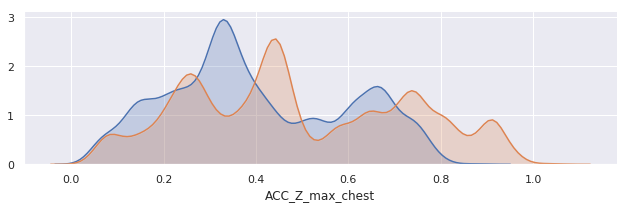

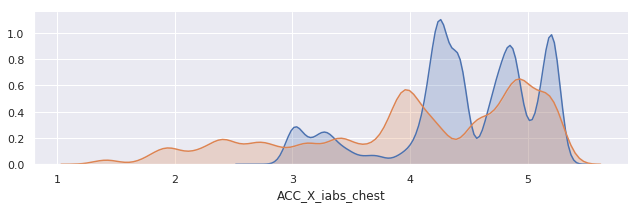

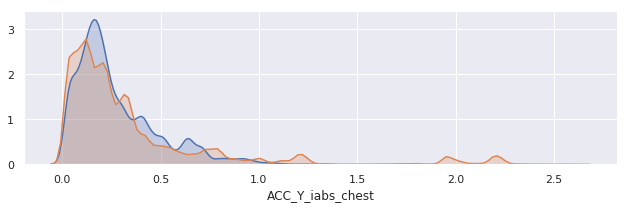

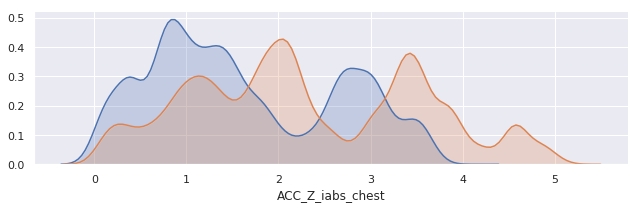

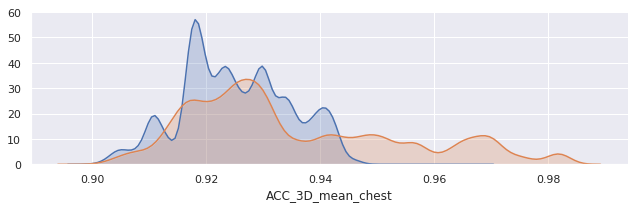

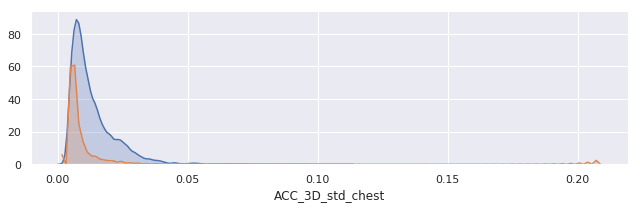

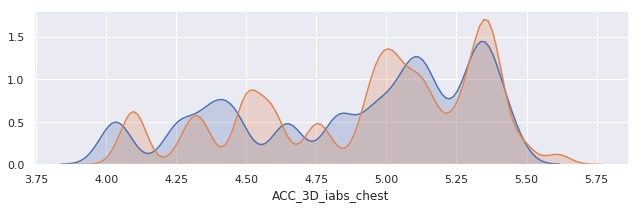

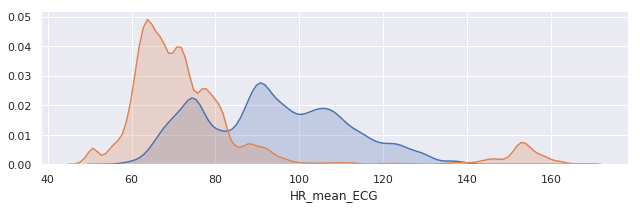

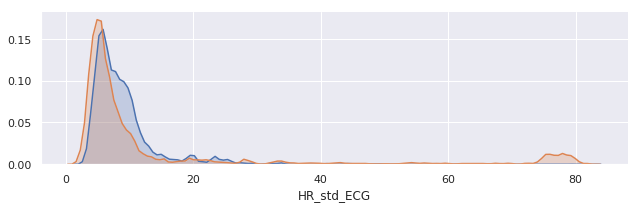

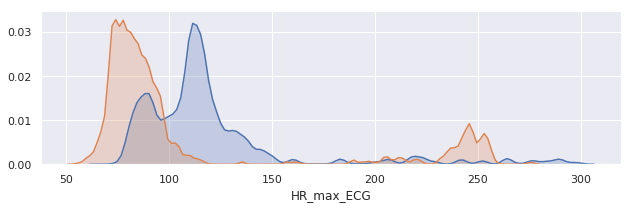

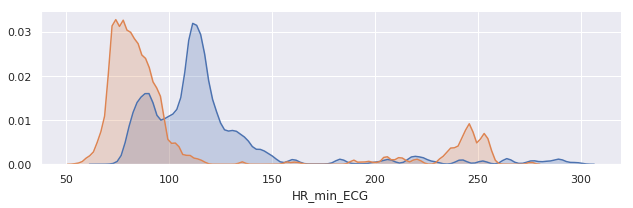

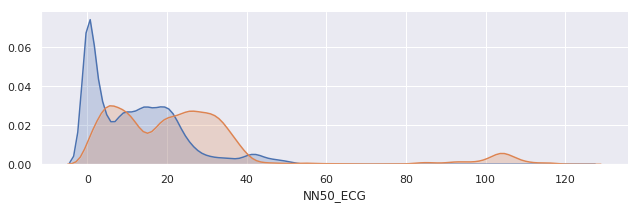

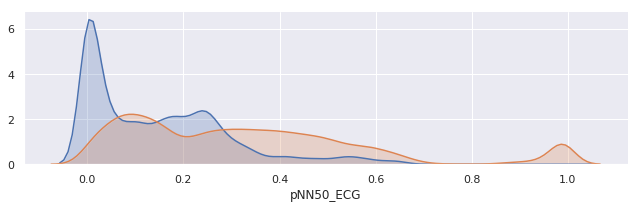

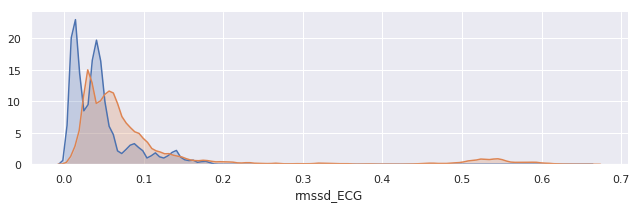

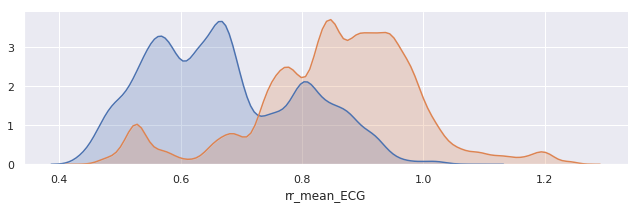

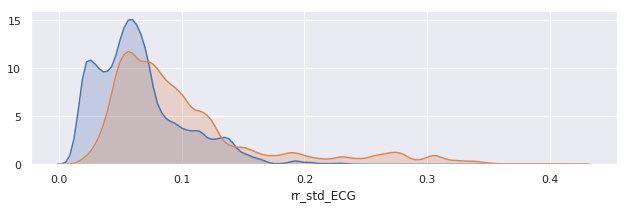

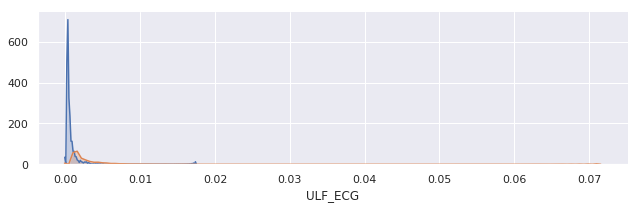

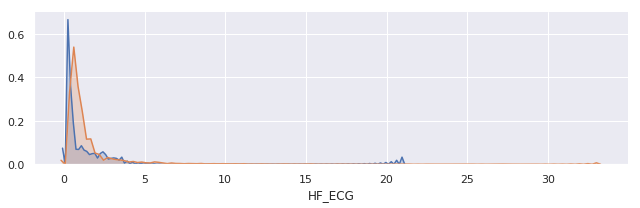

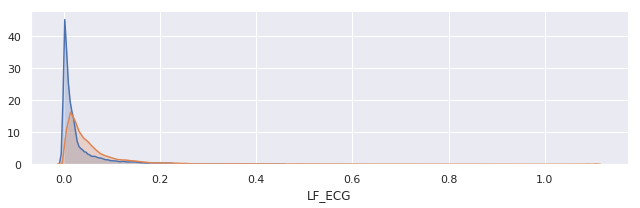

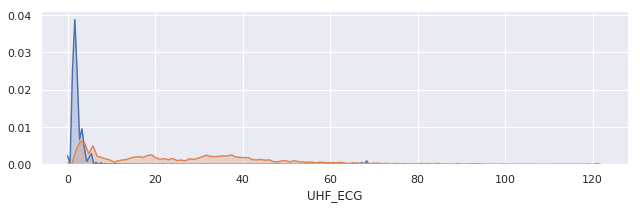

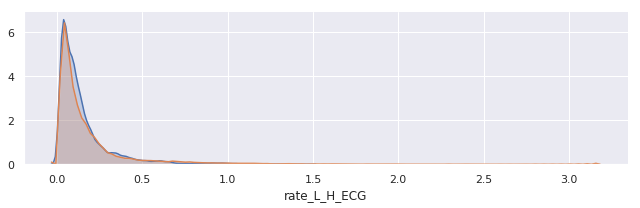

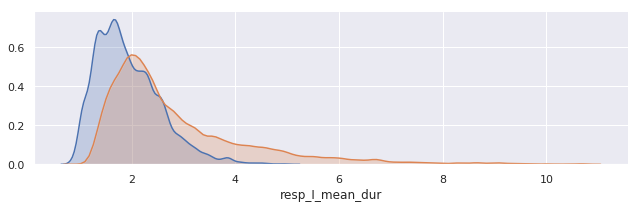

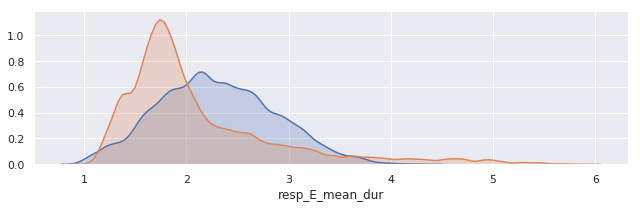

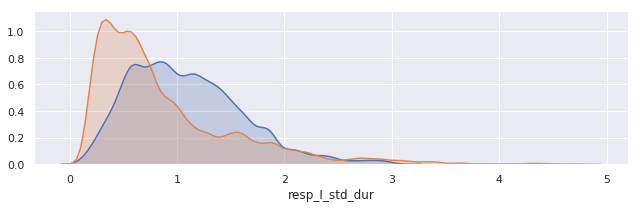

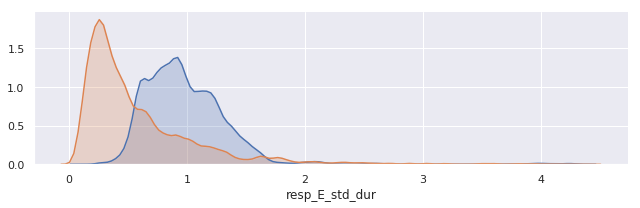

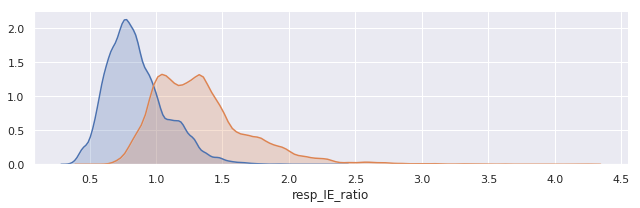

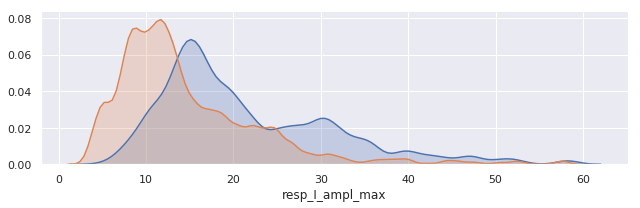

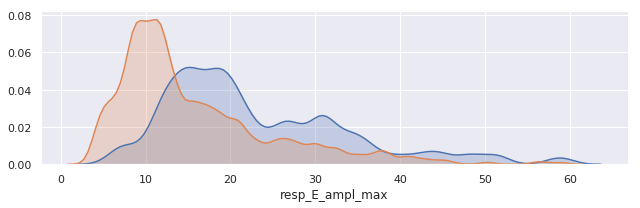

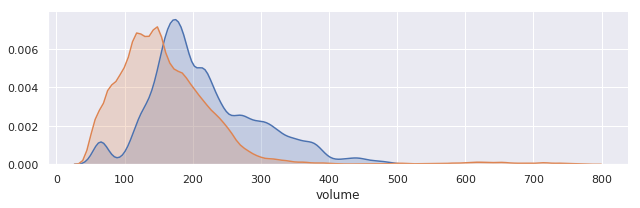

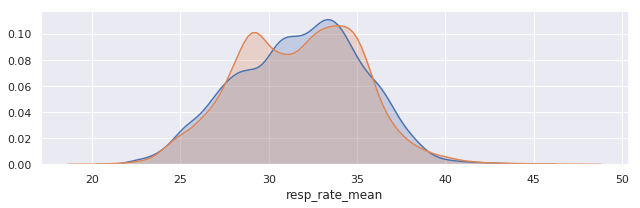

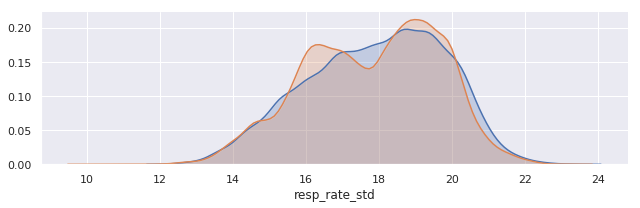

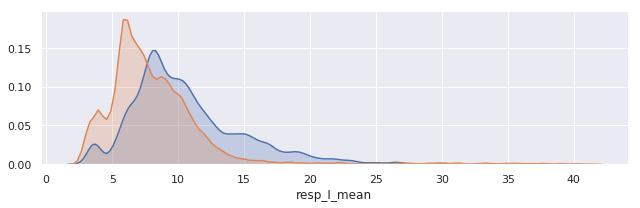

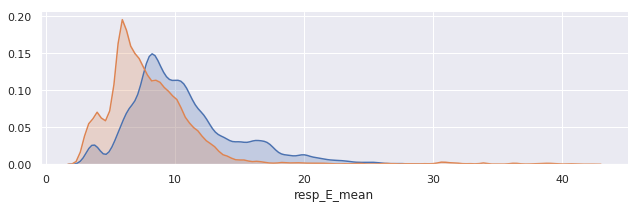

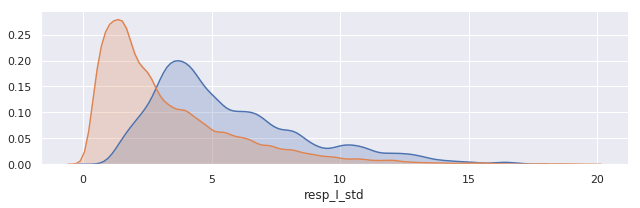

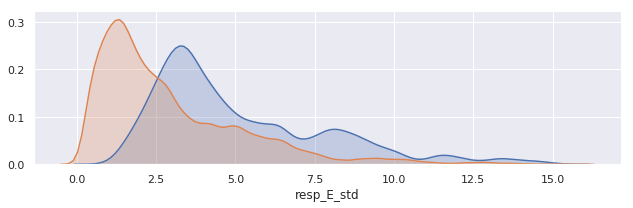

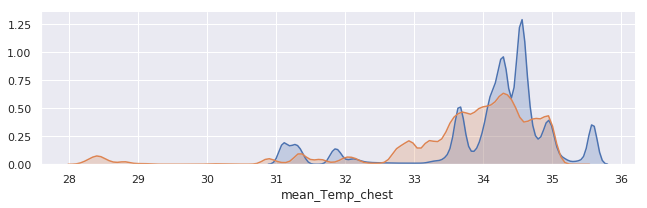

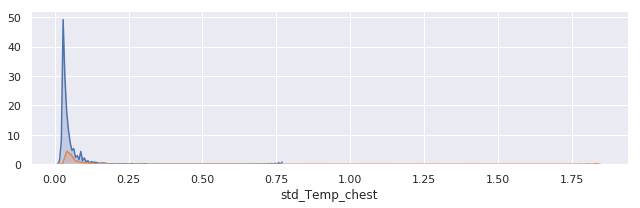

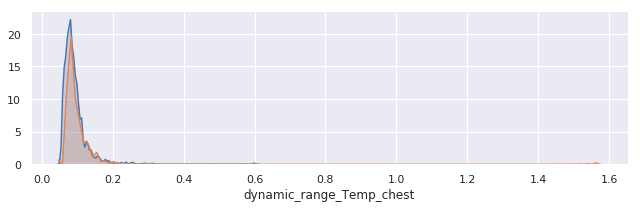

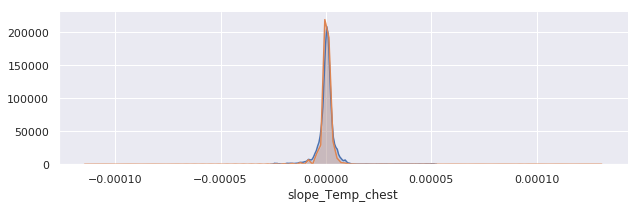

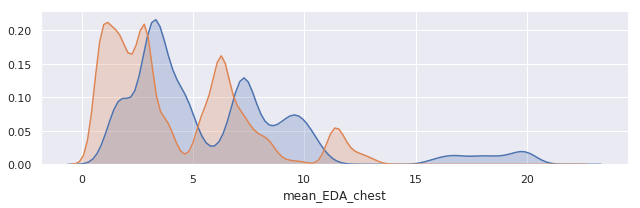

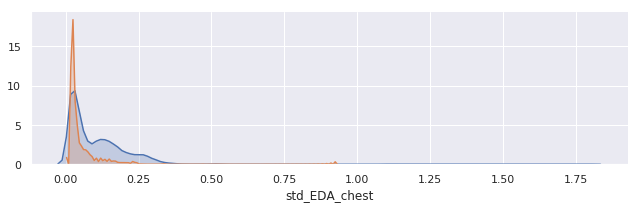

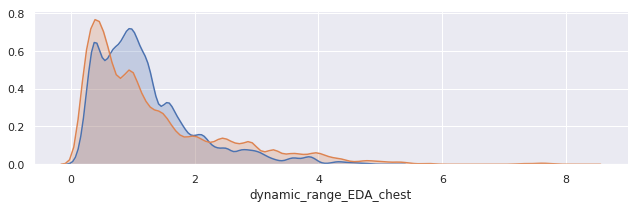

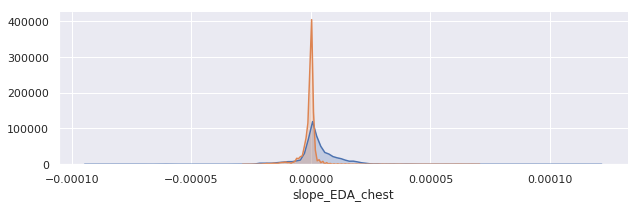

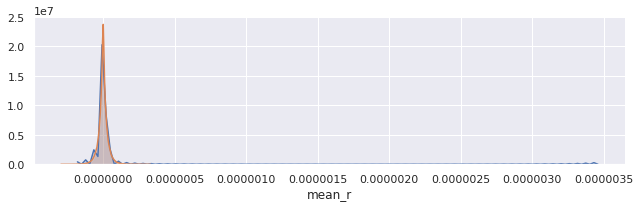

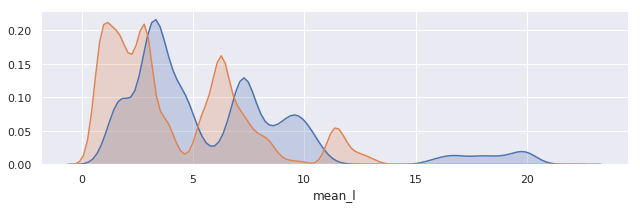

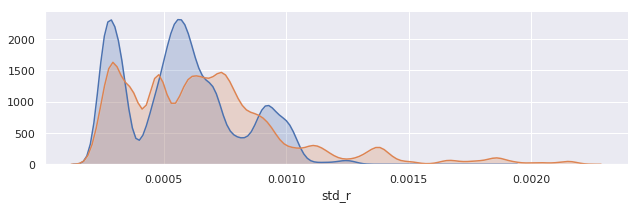

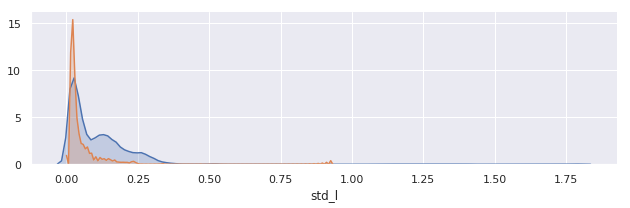

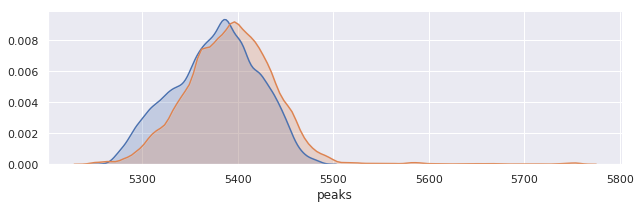

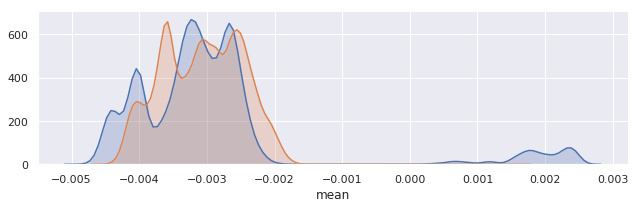

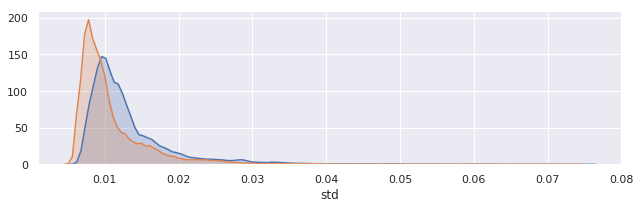

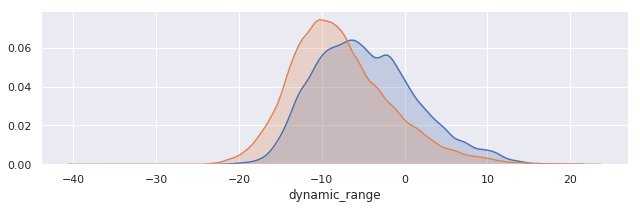

ACC_X_mean_chest  ACC_Y_mean_chest  ACC_Z_mean_chest  ACC_X_std_chest  \
0               0.878073         -0.125957         -0.273232         0.007622   
1               0.877508         -0.126700         -0.274719         0.007495   
2               0.876809         -0.127595         -0.276841         0.007494   
3               0.876161         -0.128054         -0.278792         0.007516   
4               0.875736         -0.127980         -0.281339         0.006918   
5               0.874960         -0.128274         -0.283717         0.006469   
6               0.874366         -0.128897         -0.285797         0.006403   
7               0.873452         -0.129691         -0.288158         0.006580   
8               0.872770         -0.130651         -0.289492         0.006620   
9               0.872174         -0.131284         -0.291007         0.006893   
10              0.871893         -0.131489         -0.292170         0.007089   
11              0.871646         -0.131734         -0.292969         0.007225   
12              0.871579         -0.131074         -0.293813         0.007219   
13              0.871442         -0.130498         -0.294899         0.007247   
14              0.871130         -0.130237         -0.296108         0.007333   
15              0.870609         -0.130668         -0.297682         0.007096   
16              0.869968         -0.131465         -0.299102         0.006521   
17              0.869607         -0.132053         -0.300263         0.006420   
18              0.869375         -0.132466         -0.301241         0.006222   
19              0.869059         -0.132694         -0.301831         0.006213   
20              0.868958         -0.132780         -0.302675         0.006195   
21              0.868588         -0.133046         -0.304011         0.006247   
22              0.868304         -0.133252         -0.304582         0.006290   
23              0.868413         -0.133353         -0.305011         0.006245   
24              0.868090         -0.133500         -0.305156         0.006074   
25              0.868166         -0.133498         -0.305044         0.006081   
26              0.868334         -0.133429         -0.304551         0.006049   
27              0.868635         -0.133148         -0.303770         0.006080   
28              0.868877         -0.133001         -0.303328         0.006081   
29              0.869298         -0.132828         -0.302429         0.006011   
...                  ...               ...               ...              ...   
167611          0.398468          0.014417         -0.879593         0.026067   
167612          0.399324          0.015238         -0.879011         0.026695   
167613          0.400681          0.016020         -0.878211         0.027270   
167614          0.402782          0.016521         -0.876906         0.028256   
167615          0.406598          0.016830         -0.874936         0.030122   
167616          0.411522          0.016619         -0.872146         0.032778   
167617          0.416937          0.016137         -0.868948         0.035564   
167618          0.422999          0.015479         -0.865435         0.037941   
167619          0.428857          0.014827         -0.862052         0.039000   
167620          0.434374          0.014057         -0.858865         0.038778   
167621          0.439952          0.013263         -0.855691         0.037890   
167622          0.444925          0.012414         -0.852821         0.035590   
167623          0.449762          0.011500         -0.849791         0.032426   
167624          0.455811          0.010502         -0.846379         0.028532   
167625          0.460680          0.008963         -0.843235         0.029053   
167626          0.465083          0.007756         -0.840579         0.030142   
167627          0.469642          0.006529         -0.837740         0.031138   
167628          0.473698          0.005

In [21]:

chest_datas = []
for i in [2,3,4,5,6,7,9,10,11,13,14,15,16,17]:
    chest_datas.append(pd.read_csv('features_S' + str(i) + '.pklchest'))
    chest_datas[-1].drop(['Unnamed: 0'],axis = 1, inplace= True)
    chest_datas[-1].dropna(inplace=True)
    
chest_data = pd.concat(chest_datas,axis=0,ignore_index=True)

make_features_analisys(chest_datas[1])

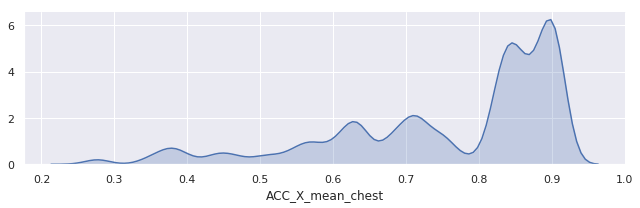

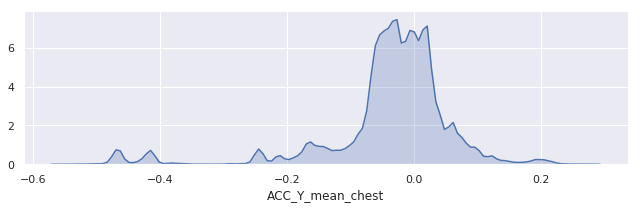

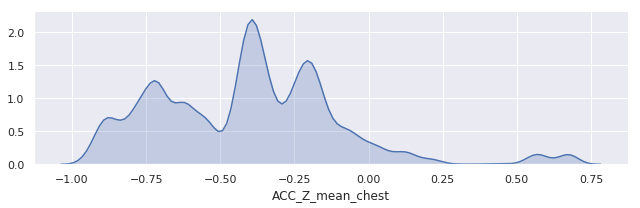

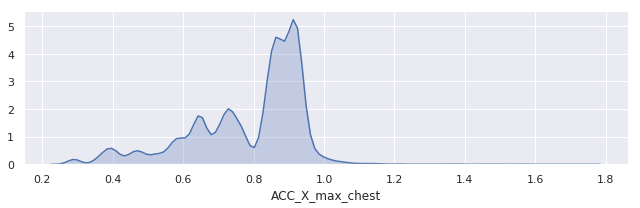

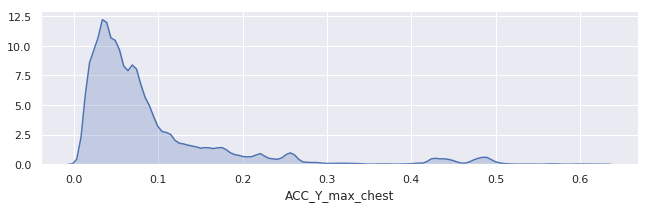

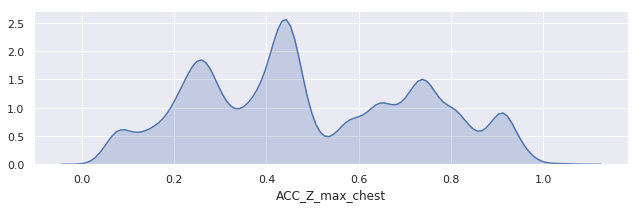

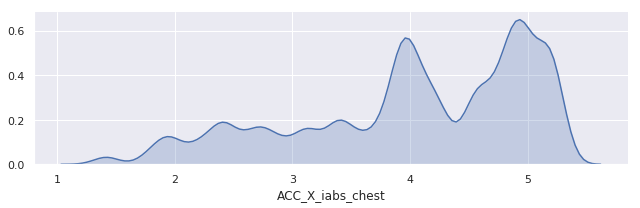

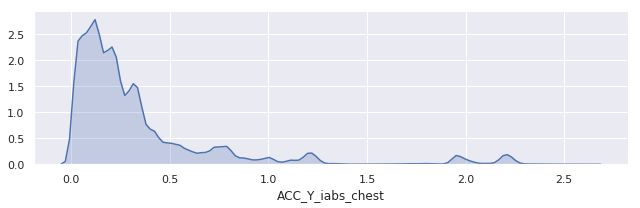

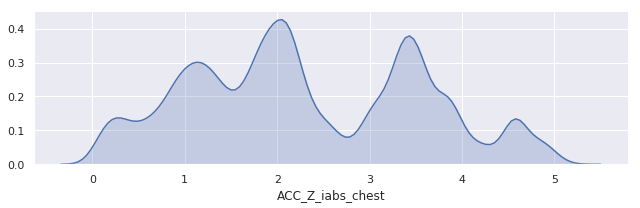

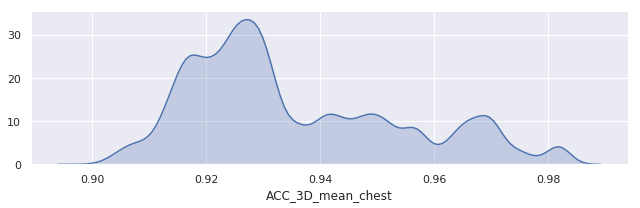

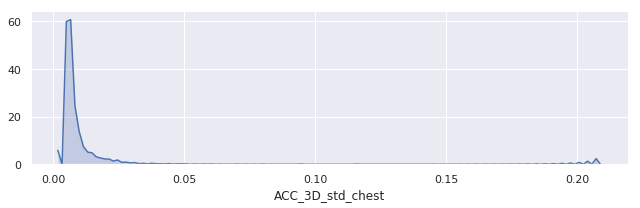

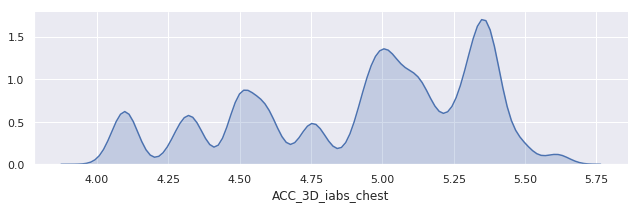

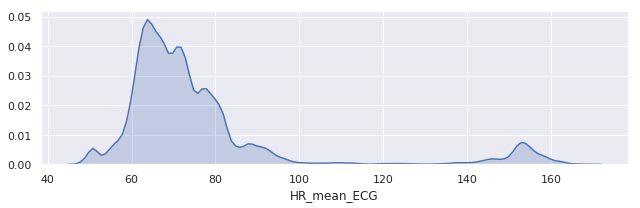

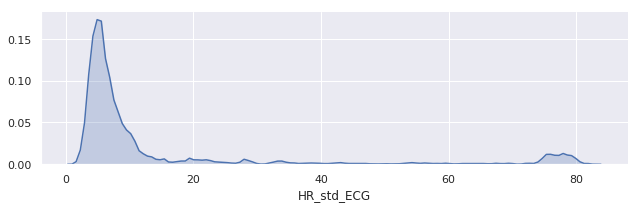

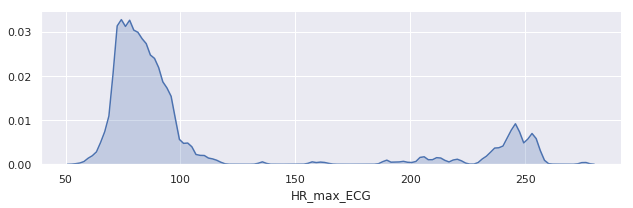

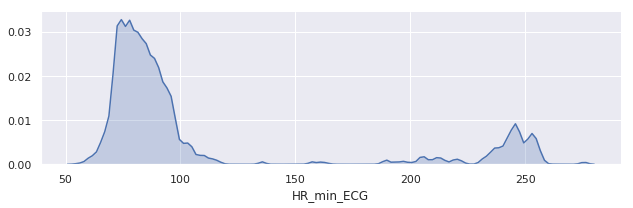

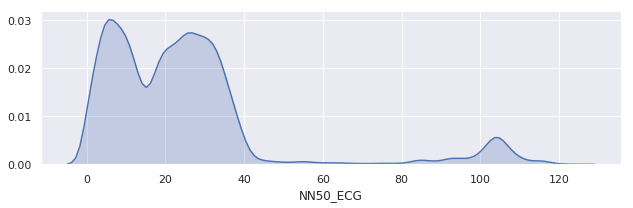

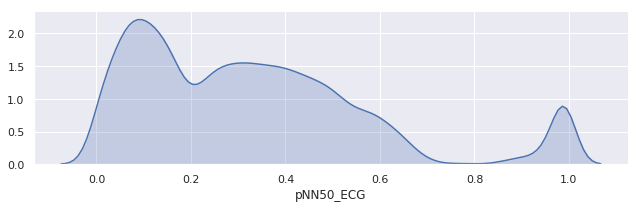

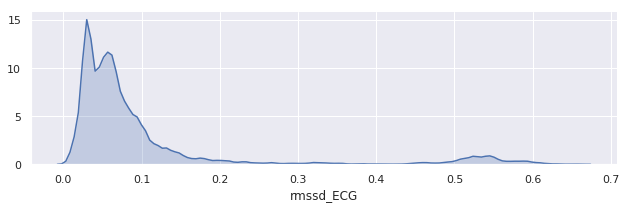

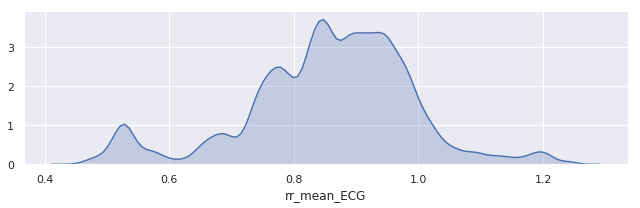

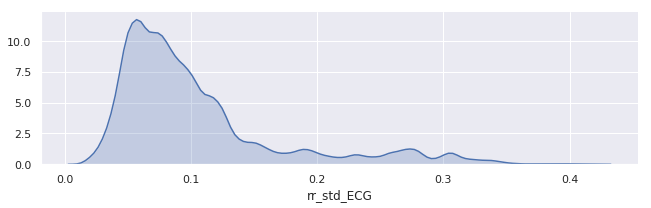

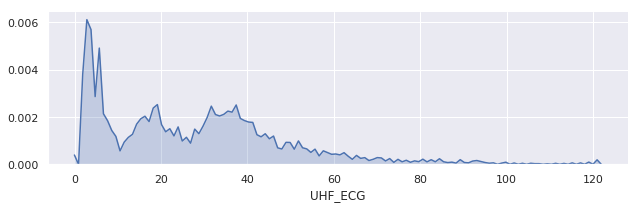

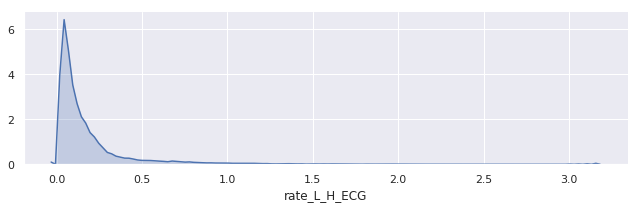

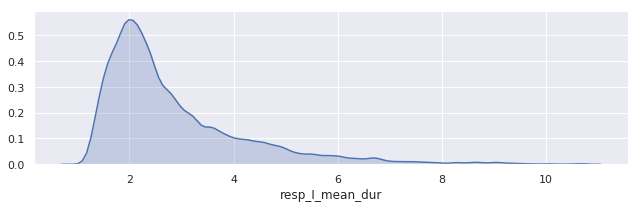

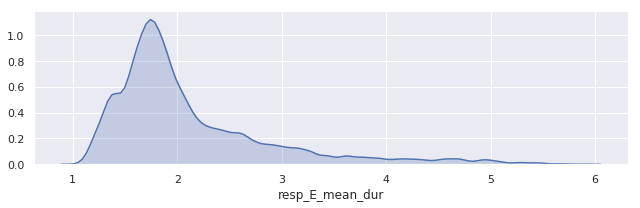

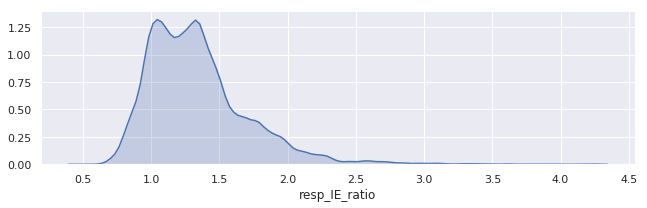

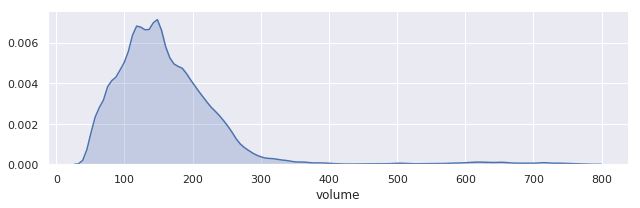

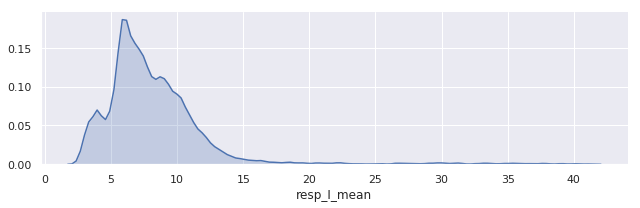

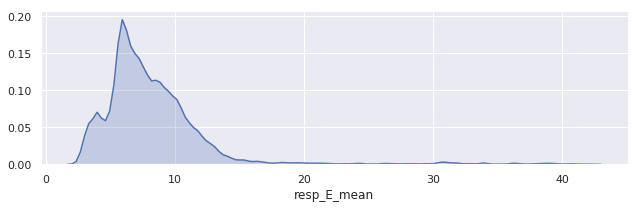

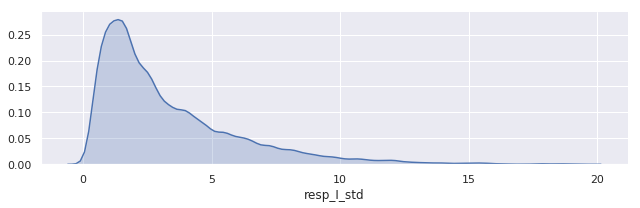

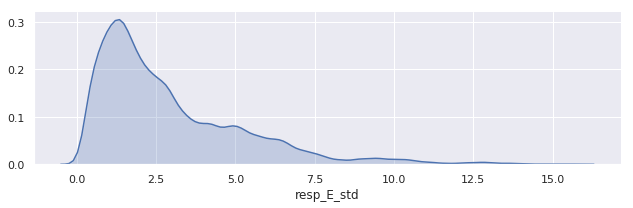

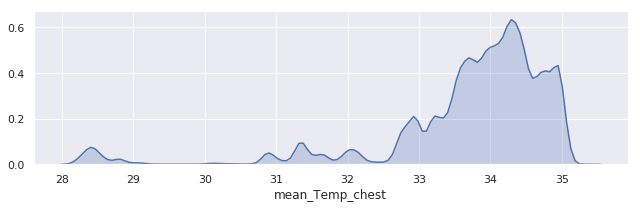

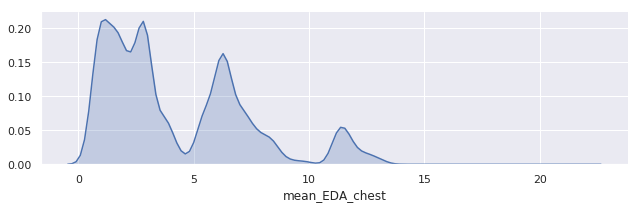

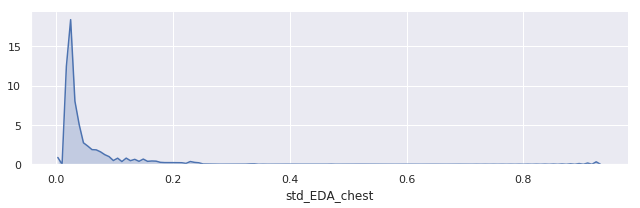

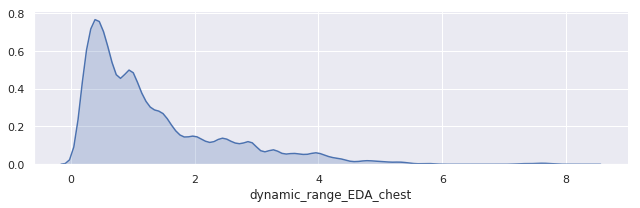

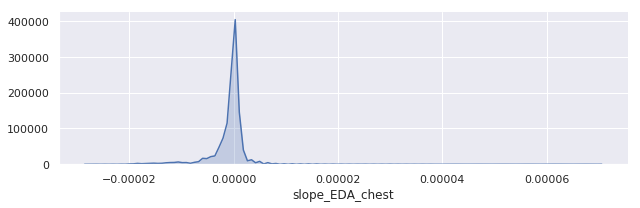

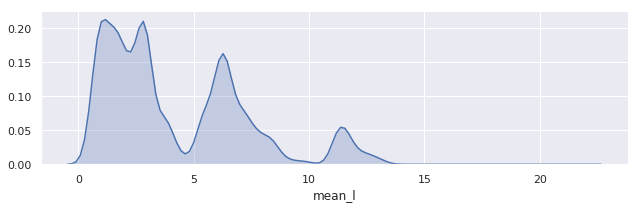

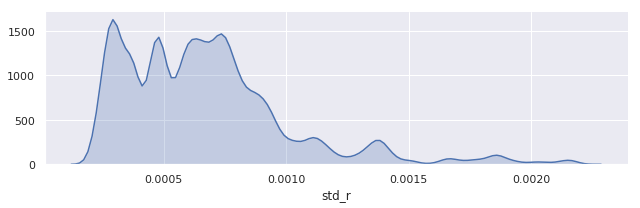

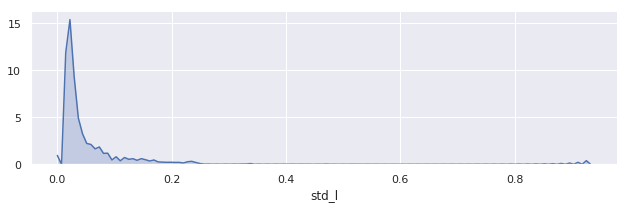

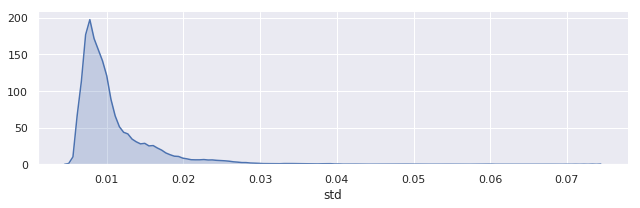

ACC_X_mean_chest  ACC_Y_mean_chest  ACC_Z_mean_chest  ACC_X_max_chest  \
0               0.878073         -0.125957         -0.273232           0.9070   
1               0.877508         -0.126700         -0.274719           0.9070   
2               0.876809         -0.127595         -0.276841           0.9070   
3               0.876161         -0.128054         -0.278792           0.9070   
4               0.875736         -0.127980         -0.281339           0.9070   
5               0.874960         -0.128274         -0.283717           0.9032   
6               0.874366         -0.128897         -0.285797           0.8946   
7               0.873452         -0.129691         -0.288158           0.8940   
8               0.872770         -0.130651         -0.289492           0.8940   
9               0.872174         -0.131284         -0.291007           0.8940   
10              0.871893         -0.131489         -0.292170           0.8940   
11              0.871646         -0.131734         -0.292969           0.8940   
12              0.871579         -0.131074         -0.293813           0.8940   
13              0.871442         -0.130498         -0.294899           0.8940   
14              0.871130         -0.130237         -0.296108           0.8940   
15              0.870609         -0.130668         -0.297682           0.8940   
16              0.869968         -0.131465         -0.299102           0.8914   
17              0.869607         -0.132053         -0.300263           0.8914   
18              0.869375         -0.132466         -0.301241           0.8914   
19              0.869059         -0.132694         -0.301831           0.8914   
20              0.868958         -0.132780         -0.302675           0.8914   
21              0.868588         -0.133046         -0.304011           0.8914   
22              0.868304         -0.133252         -0.304582           0.8914   
23              0.868413         -0.133353         -0.305011           0.8914   
24              0.868090         -0.133500         -0.305156           0.8914   
25              0.868166         -0.133498         -0.305044           0.8914   
26              0.868334         -0.133429         -0.304551           0.8914   
27              0.868635         -0.133148         -0.303770           0.8914   
28              0.868877         -0.133001         -0.303328           0.8914   
29              0.869298         -0.132828         -0.302429           0.8914   
...                  ...               ...               ...              ...   
130639          0.398468          0.014417         -0.879593           0.4490   
130640          0.399324          0.015238         -0.879011           0.4490   
130641          0.400681          0.016020         -0.878211           0.4490   
130642          0.402782          0.016521         -0.876906           0.4490   
130643          0.406598          0.016830         -0.874936           0.4738   
130644          0.411522          0.016619         -0.872146           0.4838   
130645          0.416937          0.016137         -0.868948           0.4942   
130646          0.422999          0.015479         -0.865435           0.5000   
130647          0.428857          0.014827         -0.862052           0.5000   
130648          0.434374          0.014057         -0.858865           0.5000   
130649          0.439952          0.013263         -0.855691           0.5000   
130650          0.444925          0.012414         -0.852821           0.5000   
130651          0.449762          0.011500         -0.849791           0.5000   
130652          0.455811          0.010502         -0.846379           0.5086   
130653          0.460680          0.008963         -0.843235           0.5210   
130654          0.465083          0.007756         -0.840579           0.5210   
130655          0.469642          0.006529         -0.837740           0.5332   
130656          0.473698          0.005

In [27]:
make_features_analisys(chest_data)

In [24]:
chest_data.drop(['dynamic_range', 'mean', 'peaks', 'mean_r', 'slope_Temp_chest', 'dynamic_range_Temp_chest', 'std_Temp_chest',
'resp_rate_std', 'resp_rate_mean', 'resp_E_ampl_max', 'resp_I_ampl_max', 'resp_I_std_dur', 'resp_E_std_dur', 'LF_ECG',
'HF_ECG', 'ULF_ECG', 'ACC_X_std_chest', 'ACC_Y_std_chest', 'ACC_Z_std_chest'], axis=1, inplace=True)

In [25]:
X_tr = chest_data.drop(['Target'], axis=1)    
y_tr = chest_data['Target']
X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, test_size = 0.9, random_state = 42)

#Stratified KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Fit LR
For LR best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('log_reg', LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]) 
best params = {'log_reg__C': 3, 'log_reg__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     33285
           1       0.98      0.99      0.99    117592

   micro avg       0.98      0.98      0.98    150877
   macro avg       0.97      0.96      0.97    150877
weighted avg       0.98      0.98      0.98    150877

roc_auc 	 0.994


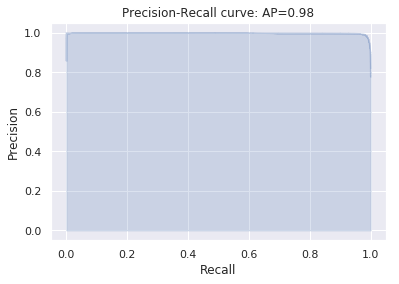

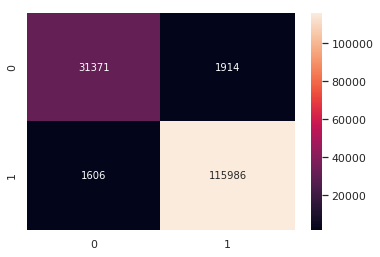

Fit RF
For RF best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]) 
best params = {'RF__max_depth': 8, 'RF__n_estimators': 800}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     33285
           1       0.99      1.00      1.00    117592

   micro avg       1.00      1.00      1.00    150877
   macro avg       1.00      0.99      0.99    150877
weighted avg       1.00      1.00      1.00    150877

roc_auc 	 1.000


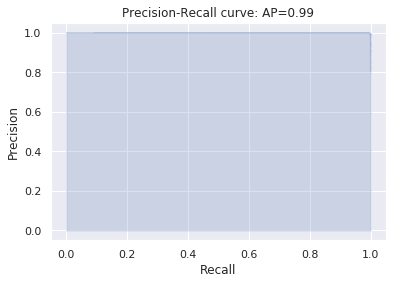

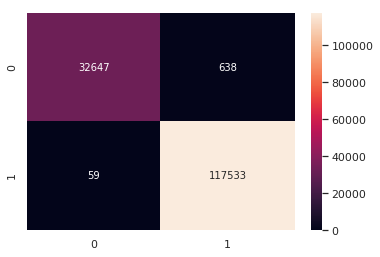

Fit XGB
For XGB best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]) 
best params = {'XGB__max_depth': 2, 'XGB__n_estimators': 500}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33285
           1       1.00      1.00      1.00    117592

   micro avg       1.00      1.00      1.00    150877
   macro avg       1.00      1.00      1.00    150877
weighted avg       1.00      1.00      1.00    150877

roc_auc 	 1.000


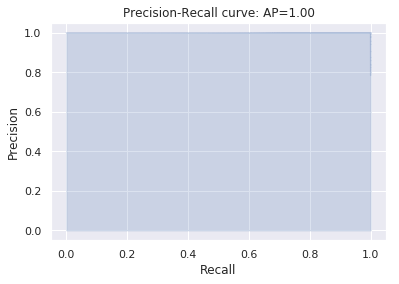

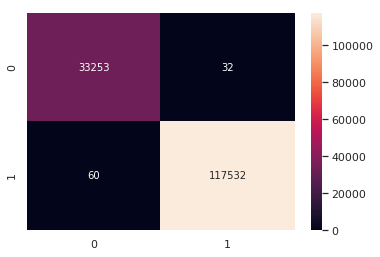

Fit LDA
For LDA best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]) 
best params = {}
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     33285
           1       0.96      0.99      0.97    117592

   micro avg       0.96      0.96      0.96    150877
   macro avg       0.95      0.92      0.93    150877
weighted avg       0.96      0.96      0.96    150877

roc_auc 	 0.990


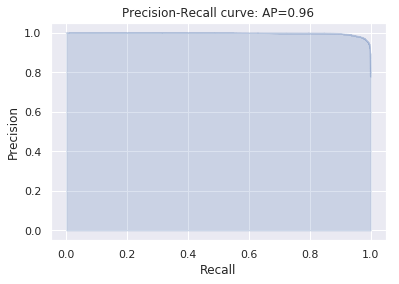

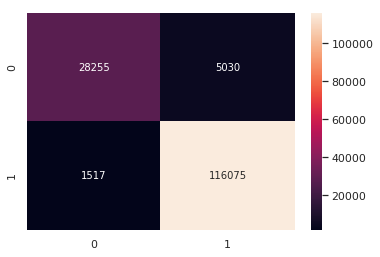

Fit QDA
For QDA best estimator = Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('QDA', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001))]) 
best params = {}
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     33285
           1       0.99      0.97      0.98    117592

   micro avg       0.97      0.97      0.97    150877
   macro avg       0.94      0.97      0.95    150877
weighted avg       0.97      0.97      0.97    150877

roc_auc 	 0.992


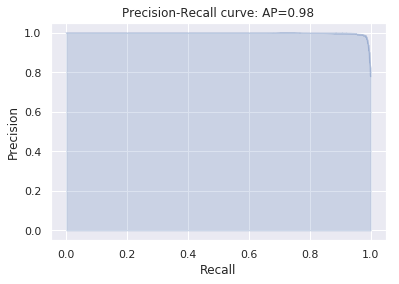

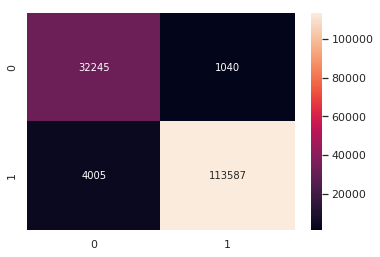

In [26]:
for model_name in models.keys():
    print('Fit ' + model_name)
    warnings.simplefilter(action='ignore')
    clf = GridSearchCV(models[model_name], parameters[model_name],
                       cv=cv, n_jobs=-1,scoring = 'f1')
    clf.fit(X_tr, y_tr)
    print ('For {} best estimator = {} \nbest params = {}'.format(model_name, clf.best_estimator_, clf.best_params_))
    # Predition part
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:,1]
    labels_proba[model_name + '_te'] = y_prob
    labels_predict[model_name + '_te'] = clf.predict(X_te)
    
    print_stats(y_te, y_pred, y_prob)

# Conclusion

We have obtained better F1 score than in the article. We suppose that it happened because of two facts:
1. we dropped obviously bad features,
2. we used grid search to optimize hyperparameters.
The best estimators are XGBoost and Random Foresr classifiers. These classifiers have one disadvantage - their fitting takes rather long time on optimal hyperparameters. But the scores are near 100%.

We have better results for chest set than for wrist one. However wrist sensors can be easier integrated into real life scenarios. For example such sensors can be implementes into smart watches.

So our results are applicable in everyday life and can be very useful in terms of detecting stress states. The value of this knowledge was already mentioned at the beginning of our research. This means that we have solved the stated problem well.

We think that ML models can be effectively used in term of defining humans' psychological and physiological states using data obtained from physio sensors. Correctly generated from raw data and after rightly selected features, suitable ML model can give quite good result.